In [1]:
#Define functions (Always run)

import pandas as pd
import numpy as np
from os import listdir
from os.path import getmtime
import subprocess

#Import only the parameters from the file
def read_params(filename = None):
    #If no filename is given, read the last .dat file
    if filename == None:
        #Animate a file
        last_date = 0
        dat_files = listdir()
        for f in dat_files:
            if f.endswith('.dat'):
                date = getmtime(f)
                if date > last_date:
                    last_date = date
                    filename = f

    #Open file and read the first lines
    data = open(filename)
    text = ''
    params = {}

    params1 = ['metric','fType']
    for i in range(len(params1)):
        row   = data.readline()
        text += row
        params.update({params1[i]:row.split(':')[1][1:-1]})
    params2 = ['p0','r0','d','deltaR','maxR','BH radius','BH mass']
    for i in range(len(params2)):
        row   = data.readline()
        text += row
        try:
            value = float(row.split(':')[1])
        except:
            value = -9999
        params.update({params2[i]:value})
    params3 = ['iterations','grids','time']
    for i in range(len(params3)):
        row   = data.readline()
        text += row
        params.update({params3[i]:int(row.split(':')[1])})
    params.update({'text':text[:-1]})

    return params

#Import the data from the file
def read_data(filename = None):
    #If no filename is given, read the last .dat file
    if filename == None:
        #Animate a file
        last_date = 0
        dat_files = listdir()
        for f in dat_files:
            if f.endswith('.dat'):
                date = getmtime(f)
                if date > last_date:
                    last_date = date
                    filename = f

    #Open file and read the first lines
    data = open(filename)
    params = read_params(filename)
    for _ in range(len(params['text'].splitlines())):
        data.readline()

    #Read data for R, phi, Phi and Pi
    rdata = list(map(float,(data.readline().split(','))[:-1]))
    alldata = data.readlines()
    data.close()
    len_6 = int(len(alldata)/6)
    if(len_6*6 !=len(alldata)):
        raise ValueError

    for i in range(6*len_6):
        alldata[i] = list(map(float,(alldata[i].replace('-nan(ind)','nan').split(','))[:-1]))
    fdata = np.array(alldata[:len_6])
    mdata = np.array(alldata[len_6:2*len_6])
    xdata = np.array(alldata[2*len_6:3*len_6])
    ydata = np.array(alldata[3*len_6:4*len_6])
    grdata = (np.array(alldata[4*len_6:5*len_6]))**(-2)
    g0data = (np.array(alldata[5*len_6:]))#**(-2)

    return rdata, fdata, xdata, ydata, grdata, g0data, mdata, params

def read_binaries(a_bin='A.bin',Phi_bin='Phi.bin',R_bin='R.bin'):
    params = {'text':'text pending'}
    with open(Phi_bin,'rb') as file:
        xdata = np.fromfile(file, dtype=np.float64)
    with open(a_bin,'rb') as file:
        grdata = np.fromfile(file, dtype=np.float64)**(-2)
    with open(R_bin,'rb') as file:
        rdata = np.fromfile(file, dtype=np.float64)
    iterations = int(len(xdata)/len(rdata))
    xdata = xdata.reshape((iterations,len(rdata)))
    grdata = grdata.reshape((iterations,len(rdata)))
    fdata = np.zeros_like(xdata)
    ydata = np.zeros_like(xdata)
    g0data = np.zeros_like(xdata)
    fdata[0] = 1
    return rdata, fdata, xdata, ydata, grdata, g0data, params
import matplotlib.animation as animation
import matplotlib.pyplot as plt


def read_binaries(a_bin='A.bin',Phi_bin='Phi.bin',R_bin='R.bin'):
    params = {'text':'text pending'}
    with open(Phi_bin,'rb') as file:
        xdata = np.fromfile(file, dtype=np.float64)
    with open(a_bin,'rb') as file:
        grdata = np.fromfile(file, dtype=np.float64)**(-2)
    with open(R_bin,'rb') as file:
        rdata = np.fromfile(file, dtype=np.float64)
    iterations = int(len(xdata)/len(rdata))
    xdata = xdata.reshape((iterations,len(rdata)))
    grdata = grdata.reshape((iterations,len(rdata)))
    fdata = np.zeros_like(xdata)
    ydata = np.zeros_like(xdata)
    g0data = np.zeros_like(xdata)
    fdata[0] = 1
    return rdata, fdata, xdata, ydata, grdata, g0data, params
import matplotlib.animation as animation
import matplotlib.pyplot as plt

#Animation in paralel of scalar fields
def animate_data(filename = None, ipf = 1,output_name = None,ls='-',marker='',ms=0.5,ftype='dat',dpi=120):
    if ftype=='dat':
        r,f,x,y,gr,g0,m,params = read_data(filename)
    elif ftype=='bin':
        r,f,x,y,gr,g0,m,params = read_binaries()
    else:
        raise ValueError

    plt.ioff()
    IPF = ipf #Iterations per frame
    iterations = len(f)
    if ipf>iterations:
        raise ValueError
    FRAMES = int(iterations/IPF)

    fig, ax = plt.subplots(3,2,figsize=(12,12),dpi=dpi)

    #Plot data at the first iteration
    Fplot = ax[0,0].plot(r,f[0] ,ls=ls,marker=marker,markersize=ms)[0]
    Mplot = ax[0,1].plot(r,m[0] ,ls=ls,marker=marker,markersize=ms)[0]
    Xplot = ax[1,0].plot(r,x[0] ,ls=ls,marker=marker,markersize=ms)[0]
    Yplot = ax[2,0].plot(r,y[0] ,ls=ls,marker=marker,markersize=ms)[0]
    Aplot = ax[1,1].plot(r,gr[0],ls=ls,marker=marker,markersize=ms)[0]
    Bplot = ax[2,1].plot(r,g0[0],ls=ls,marker=marker,markersize=ms)[0]
    ax[1,0].set_ylim( -3*ax[1,0].get_ylim()[1],3*ax[1,0].get_ylim()[1])
    ax[2,0].set_ylim(  ax[1,0].get_ylim())
    ax[1,1].set_ylim(-0.1,1.1)
    ax[2,1].set_ylim(-0.1,1.1)

    #Set up text
    #ax[0,1].remove()
    #ax[0,0].text(1.21,0.98,params['text'],verticalalignment='top',transform=ax[0,0].transAxes)
    text = params['text'].splitlines()
    text1 = text[:len(text)//2]
    text2 = text[len(text)//2:]
    text1 = '\n'.join(text1)
    text2 = '\n'.join(text2)
    ax[0,0].text(0.95,1.1,text1,verticalalignment='bottom',horizontalalignment='right',transform=ax[0,0].transAxes)
    ax[0,0].text(1.05,1.1,text2,verticalalignment='bottom',horizontalalignment='left',transform=ax[0,0].transAxes)
    

    #Make limits for phi plot based on maximum initial difference from external point
    #try:
    #    deltaLim = max(m[0][-1] -ax[0,0].get_ylim()[0], ax[0,0].get_ylim()[1] -m[0][-1])
    #    ax[0,0].set_ylim(f[0][-1]-deltaLim,f[0][-1]+deltaLim)
    #except:
    #    None
    ax[0,0].set_title('$\phi$')
    ax[1,0].set_title('$\Phi$')
    ax[2,0].set_title('$\Pi$')
    ax[0,1].set_title('$M$')
    ax[1,1].set_title('$g^{rr}$')
    ax[2,1].set_title('$g^{00}$')

    #Create a function that changes the data every frame
    def animate(i):
        it = i*IPF
        Fplot.set_data(r,f[it])
        Mplot.set_data(r,m[it])
        Xplot.set_data(r,x[it])
        Yplot.set_data(r,y[it])
        Aplot.set_data(r,gr[it])
        Bplot.set_data(r,g0[it])
        return None

    #Make the animation
    anim = animation.FuncAnimation(fig, animate, frames=FRAMES,
                                    interval=100, repeat_delay=3000)
    if (filename == None):
        filename = 'Output.dat'
    if (output_name == None):
        output_name = filename[:-3]+'gif'
    anim.save(output_name,writer='pillow')
    plt.close()


def plot_last(filename = None, diff_from_collapse=-1, replace_nan=-1):
    r,f,x,y,gr,g0,m,params = read_data(filename)


    iterations = len(f)

    #Find the last iteration before collapse
    last_iteration = iterations-1
    for i in range(iterations):
        f_nan  = np.any(np.isnan( f[i]))
        #f_nan  = False
        x_nan  = np.any(np.isnan( x[i]))
        y_nan  = np.any(np.isnan( y[i]))
        gr_nan = np.any(np.isnan(gr[i]))
        g0_nan = np.any(np.isnan(g0[i]))
        if np.any((f_nan,x_nan,y_nan,gr_nan,g0_nan)):
            last_iteration = i+diff_from_collapse
            break

    fig, ax = plt.subplots(3,2,figsize=(12,12),dpi=100)

    ax[0,0].plot(r,np.nan_to_num( f[last_iteration],nan=replace_nan))[0]
    ax[1,0].plot(r,np.nan_to_num( x[last_iteration],nan=replace_nan))[0]
    ax[2,0].plot(r,np.nan_to_num( y[last_iteration],nan=replace_nan))[0]
    ax[1,1].plot(r,np.nan_to_num(gr[last_iteration],nan=replace_nan))[0]
    ax[2,1].plot(r,np.nan_to_num(g0[last_iteration],nan=replace_nan))[0]
    ax[0,0].text(1.21,0.98,params['text']+f'\nPrinted iteration: {last_iteration}',verticalalignment='top',transform=ax[0,0].transAxes)
    ax[0,1].remove()
    #ax[1,1].set_ylim(-0.1,1.1)
    #ax[2,1].set_ylim(-0.1,1.1)
    ax[0,0].set_title('$\phi$')
    ax[1,0].set_title('$\Phi$')
    ax[2,0].set_title('$\Pi$')
    ax[1,1].set_title('$g^{rr}$')
    ax[2,1].set_title('$g^{00}$')

    plt.show()

#Animation in paralel of scalar fields
def animate_multiple(filenames, ipf = 1,output_name = None,ls='-',marker='',ms=0.5):
    Nfiles = len(filenames)
    r= []
    x= []
    params= []
    for iN,file in enumerate(filenames):
        r_,f_,x_,y_,gr_,g0_,params_ = read_data(file)
        r.append(r_)
        x.append(x_)
        params.append(params_)
    #r,f,x,y,gr,g0,params = read_binaries()

    plt.ioff()
    IPF = ipf #Iterations per frame
    iterations = len(x[0])
    if ipf>iterations:
        raise ValueError
    FRAMES = int(iterations/IPF)

    fig, ax = plt.subplots(Nfiles,1,figsize=(10,Nfiles*2),dpi=120)
    Xplot = []
    for iN in range(Nfiles):
        Xplot.append(ax[iN].plot(r[iN],x[iN][0] ,ls=ls,marker=marker,markersize=ms)[0])
        #ax[iN].text(1.21,0.98,params[iN]['text'],verticalalignment='top',transform=ax[iN].transAxes)
        ax[iN].set_title(f'$\Phi$\tKO coeff = {params[iN]["Kreiss-Oliger"]}')
    fig.tight_layout()

    #Create a function that changes the data every frame
    def animate(i):
        it = i*IPF
        for iN in range(Nfiles):
            Xplot[iN].set_data(r[iN],x[iN][it])
        return None

    #Make the animation
    anim = animation.FuncAnimation(fig, animate, frames=FRAMES,
                                    interval=100, repeat_delay=3000)
    if (output_name == None):
        output_name = 'Multi_anim.gif'
    anim.save(output_name,writer='pillow')
    plt.close()
        


In [4]:
#3D plot

def animate_2D(filename = None, ipf = 1,output_name = None,ls='-',marker='',ms=0.5,ftype='dat',dpi=120,crit=True):
    if ftype=='dat':
        r,f,x,y,gr,g0,m,params = read_data(filename)
    elif ftype=='bin':
        r,f,x,y,gr,g0,m,params = read_binaries()
    else:
        raise ValueError

    plt.ioff()
    IPF = ipf #Iterations per frame
    iterations = len(f)
    if ipf>iterations:
        raise ValueError
    FRAMES = int(iterations/IPF)

    fig, ax = plt.subplots(2,1,figsize=(6,6),dpi=dpi)
    fig.patch.set_facecolor('lightblue')

    #Plot data at the first iteration
    Fplot = ax[0].plot(r,f[0] ,ls=ls,marker=marker,markersize=ms)[0]
    Bplot = ax[1].plot(r,g0[0],ls=ls,marker=marker,markersize=ms)[0]
    
    ax[0].set_title('$\phi$')
    ax[1].set_title('$\\alpha$')
    ylim = ax[0].get_ylim()
    ax[0].set_ylim(-ylim[1],2*ylim[1])
    if crit:
        ax[1].set_ylim([-0.1,1.1])
    else:
        y_minor = 1-ax[1].get_ylim()[0]
        ax[1].set_ylim([1-8*y_minor,1+0.5*y_minor])

    fig.tight_layout()

    #Create a function that changes the data every frame
    def animate(i):
        it = i*IPF
        Fplot.set_data(r,f[it])
        Bplot.set_data(r,g0[it])
        return None

    #Make the animation
    anim = animation.FuncAnimation(fig, animate, frames=FRAMES,
                                    interval=100, repeat_delay=3000)
    if (filename == None):
        filename = 'Output.dat'
    if (output_name == None):
        output_name = filename[:-3]+'gif'
    anim.save(output_name,writer='pillow')
    plt.close()

def animate_1(filename = None, ipf = 1,output_name = None,ls='-',marker='',ms=0.5,ftype='dat',dpi=120):
    if ftype=='dat':
        r,f,x,y,gr,g0,m,params = read_data(filename)
    elif ftype=='bin':
        r,f,x,y,gr,g0,m,params = read_binaries()
    else:
        raise ValueError

    plt.ioff()
    IPF = ipf #Iterations per frame
    iterations = len(f)
    if ipf>iterations:
        raise ValueError
    FRAMES = int(iterations/IPF)

    fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=dpi)
    fig.patch.set_facecolor('lightblue')
    Fplot = ax.step(r,f[0] ,ls=ls,marker=marker,markersize=ms)[0]
    
    #ax.set_title('$\phi$')
    ylim = ax.get_ylim()
    ax.set_ylim(-ylim[1],2*ylim[1])
    ax.set_yticks([])
    ax.set_xticks([])

    fig.tight_layout()

    #Create a function that changes the data every frame
    def animate(i):
        it = i*IPF
        Fplot.set_data(r,f[it])
        return None

    #Make the animation
    anim = animation.FuncAnimation(fig, animate, frames=FRAMES,
                                    interval=100, repeat_delay=6000)
    if (filename == None):
        filename = 'Output.dat'
    if (output_name == None):
        output_name = filename[:-3]+'gif'
    anim.save(output_name,writer='pillow')
    plt.close()

In [2]:
#Animation of only alpha
def animate_alpha(filename = None, ipf = 1,output_name = None,ls='-',marker='',ms=0.5,ftype='dat'):
    if ftype=='dat':
        r,f,x,y,gr,g0,params = read_data(filename)
    elif ftype=='bin':
        r,f,x,y,gr,g0,params = read_binaries()
    else:
        raise ValueError

    plt.ioff()
    IPF = ipf #Iterations per frame
    iterations = len(f)
    if ipf>iterations:
        raise ValueError
    FRAMES = int(iterations/IPF)

    fig, ax = plt.subplots(1,figsize=(6,4),dpi=120)

    Bplot = ax.plot(r,g0[0],ls=ls,marker=marker,markersize=ms)[0]
    ax.set_ylim(-0.1,1.1)
    ax.set_title('$\\alpha$')

    #Create a function that changes the data every frame
    def animate(i):
        it = i*IPF
        Bplot.set_data(r,g0[it])
        return None

    #Make the animation
    anim = animation.FuncAnimation(fig, animate, frames=FRAMES,
                                    interval=100, repeat_delay=3000)
    if (output_name == None):
        output_name = filename[:-3]+'gif'
    anim.save(output_name,writer='pillow')
    plt.close()

In [15]:
animate_2D(ipf=20,crit=False)

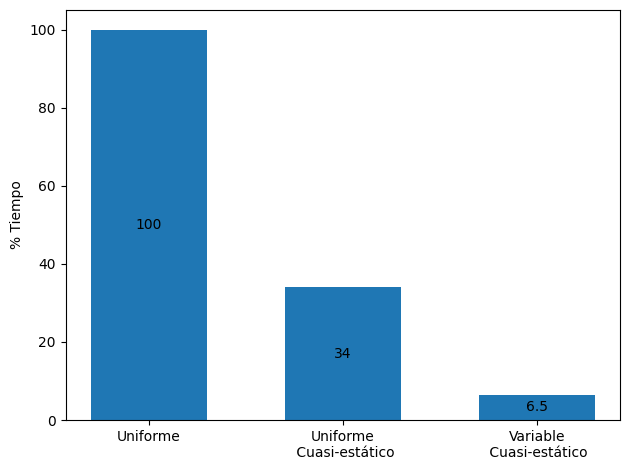

In [117]:
Types = ('Uniforme','Uniforme\n Cuasi-estático','Variable\n Cuasi-estático')
data = np.array([100,34,6.5])
width = 0.6  # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
#fig.patch.set_facecolor('lightblue')
bottom = np.zeros(3)
p = ax.bar(Types, data, width,  bottom=bottom)
bottom += data
ax.bar_label(p, label_type='center')
ax.set_ylabel('% Tiempo')
#ax.set_title('Comparación del tiempo de ejecución')
fig.tight_layout()
plt.show()

In [10]:
import subprocess
import numpy as np

fType = "1"
r0 = "0"
d  = "0"
ko  = "0.0"
maxR = "50"
iterations = "30000"
p0 = '0.00002'

output = subprocess.check_output([".\CollapseMinkowski.exe",  fType, p0, r0, d, '0.025', maxR, "16000"], text=True,)
print(f"{output}")
animate_1(ipf=16,output_name='Minkowski1.gif')
output = subprocess.check_output([".\CollapseMinkowski.exe",  fType, p0, r0, d, '0.1', maxR, "4000"], text=True,)
print(f"{output}")
animate_1(ipf=4,output_name='Minkowski2.gif')
output = subprocess.check_output([".\CollapseMinkowski.exe",  fType, p0, r0, d, '0.2', maxR, "2000"], text=True,)
print(f"{output}")
animate_1(ipf=2,output_name='Minkowski3.gif')

Total iterations: 16000
Finished, total time: 1s

Total iterations: 4000
Finished, total time: 0s

Total iterations: 2000
Finished, total time: 0s



# Random testing

In [12]:
#Arbitrary run

import subprocess
import numpy as np

fType = "1"
r0 = "0"
d  = "0"
ko  = "0.0"
deltaR = '0.01'
maxR = "50"
iterations = "25000"
p0 = '0.0000001'

output = subprocess.check_output([".\VcollapseNoStop.exe",  fType, '0.000005', r0, d, deltaR, maxR, iterations], text=True,)
print(f"{output}")
animate_2D(ipf=5,output_name='SuperCrit.gif')

output = subprocess.check_output([".\VcollapseNoStop.exe",  fType, '0.0000001', r0, d, deltaR, maxR, iterations], text=True,)
print(f"{output}")
animate_2D(ipf=5,output_name='SubCrit.gif',crit=False)

#iterations = "200000"
#deltaR = '0.001'
#output = subprocess.check_output([".\Collapse.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
#print(f"{output}")
#animate_data(output_name='Uniform.gif')


Total iterations: 25000
nR: 5001
nR_extended: 5001
dR_pointer: 0.010000
dT_pointer: 0.002000
grid range: 1.000000e-50 - 5.000000e+01

nR: 2501
nR_extended: 2517
dR_pointer: 0.010000
dT_pointer: 0.002000
grid range: 2.500000e+01 - 5.000000e+01

nR: 2501
nR_extended: 2533
dR_pointer: 0.005000
dT_pointer: 0.001000
grid range: 1.250000e+01 - 2.500000e+01

nR: 2501
nR_extended: 2533
dR_pointer: 0.002500
dT_pointer: 0.000500
grid range: 6.250000e+00 - 1.250000e+01

nR: 5001
nR_extended: 5017
dR_pointer: 0.001250
dT_pointer: 0.000250
grid range: 1.000000e-50 - 6.250000e+00

Finished, total time: 116s

Total iterations: 25000
nR: 5001
nR_extended: 5001
dR_pointer: 0.010000
dT_pointer: 0.002000
grid range: 1.000000e-50 - 5.000000e+01

nR: 2501
nR_extended: 2517
dR_pointer: 0.010000
dT_pointer: 0.002000
grid range: 2.500000e+01 - 5.000000e+01

nR: 2501
nR_extended: 2533
dR_pointer: 0.005000
dT_pointer: 0.001000
grid range: 1.250000e+01 - 2.500000e+01

nR: 2501
nR_extended: 2533
dR_pointer: 0.002

In [10]:
#Animate last file
animate_data(filename='Output_191042.dat',ipf=10)

In [ ]:
#Animate a file
dat_files = listdir()
dat_files = [f for f in dat_files if (f.startswith('Output') and f.endswith('.dat'))]
print('Índice  Nombre')
for i in range(len(dat_files)):
    print(f'{i}       {dat_files[i]}')
file_dat= input("Ingrese el índice o nombre del archivo que desea graficar: ")
if not file_dat.endswith('.dat'):
    file_dat = dat_files[int(file_dat)]

print(f'Graficando {file_dat} ...')
animate_data(file_dat,5,ls='',marker='.',ms=1)
#animate_alpha(file_dat,40,ms=1)
print(f'Animación de {file_dat} lista')
#plot_last(inlist_dat,0)

In [9]:
#Animate all files
from os import listdir
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
        animate_data(file,ipf=10)
        print(f'Animation for {file} ready')

Animation for Output_201658.dat ready


In [ ]:
#Plot last frame of all files
from os import listdir
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
        plot_last(file,0)

## Test on different parameters

In [26]:
#Run for tanh function

import subprocess
import numpy as np

fType = "0"
p0s = np.linspace(0.04,0.08,6)
r0 = "0"
d  = "0"
q  = "0"
iterations = "30000"
maxR = "50"
processes = "0"
for p0 in p0s:
    output = subprocess.check_output([".\Collapse.exe", fType, str(p0), r0, d, q, maxR, iterations, processes], text=True,)
    print(f"{output}")

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished

Parallel execution:
Total iterations: 30000
Finished



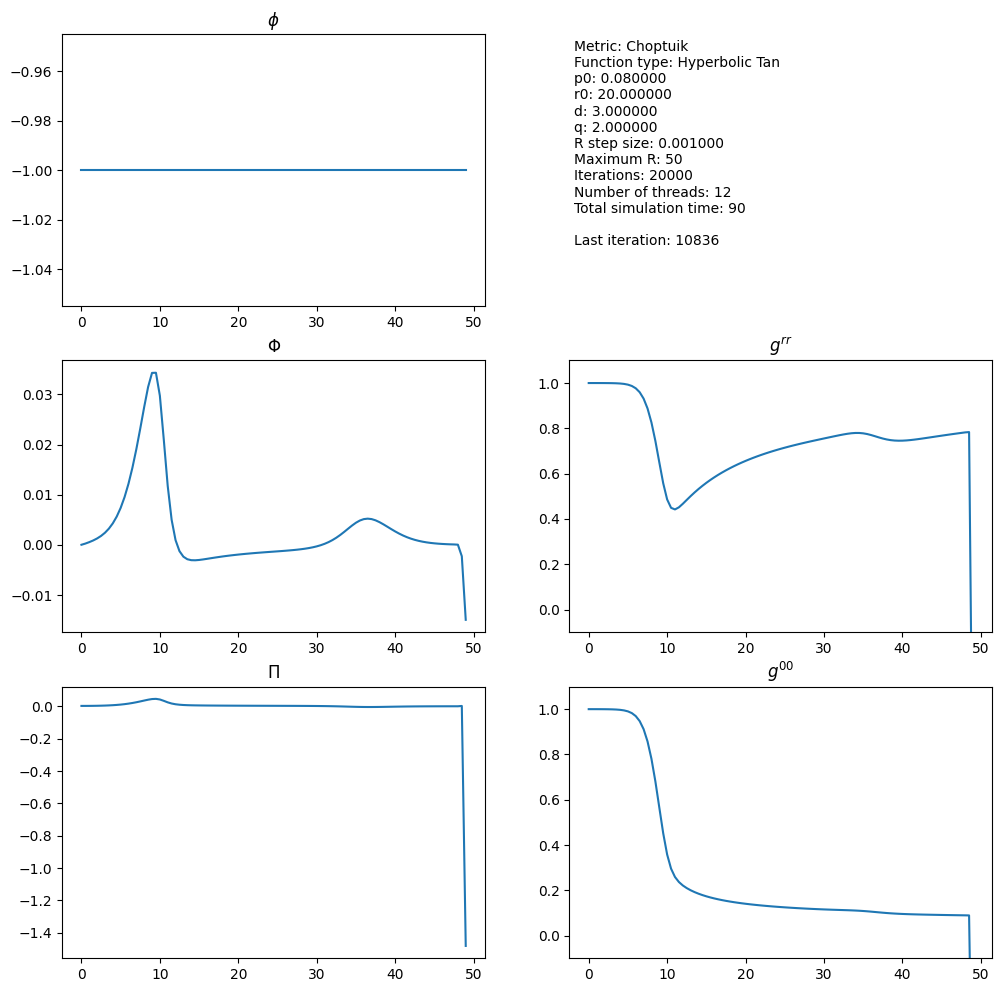

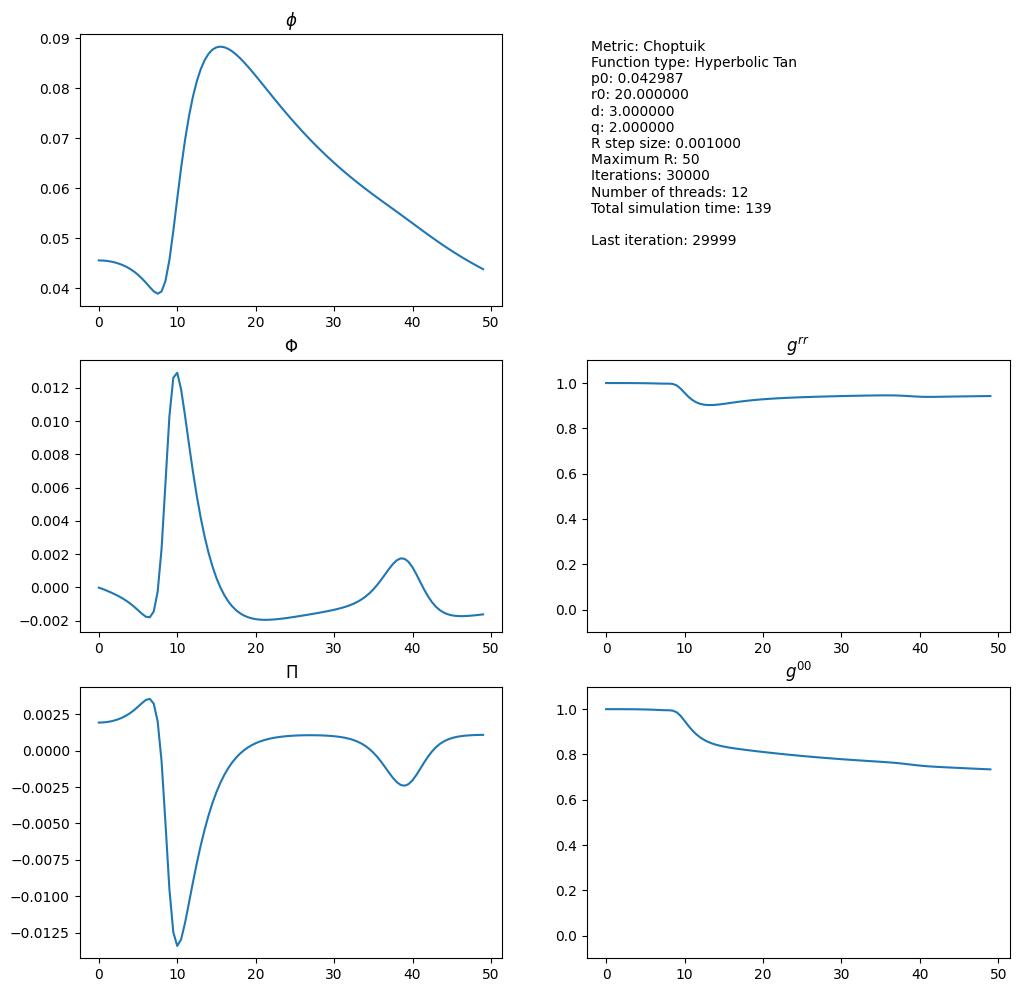

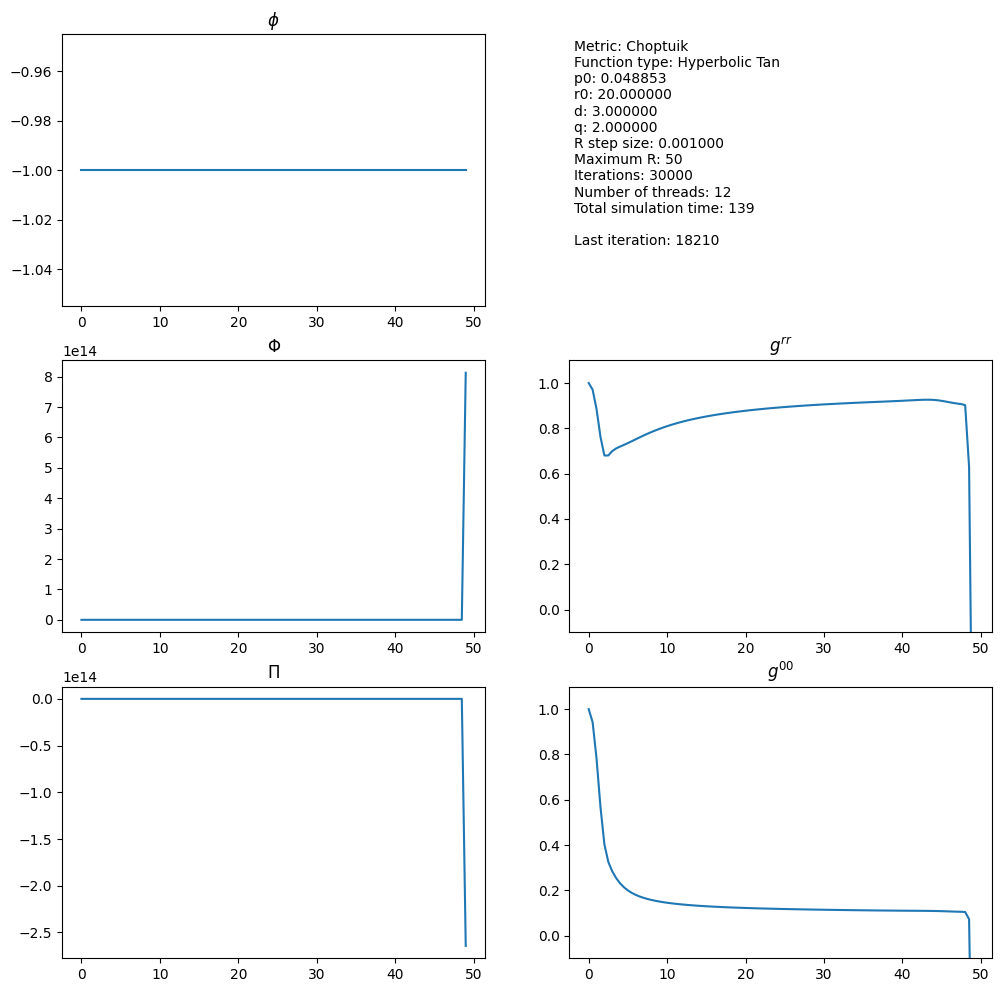

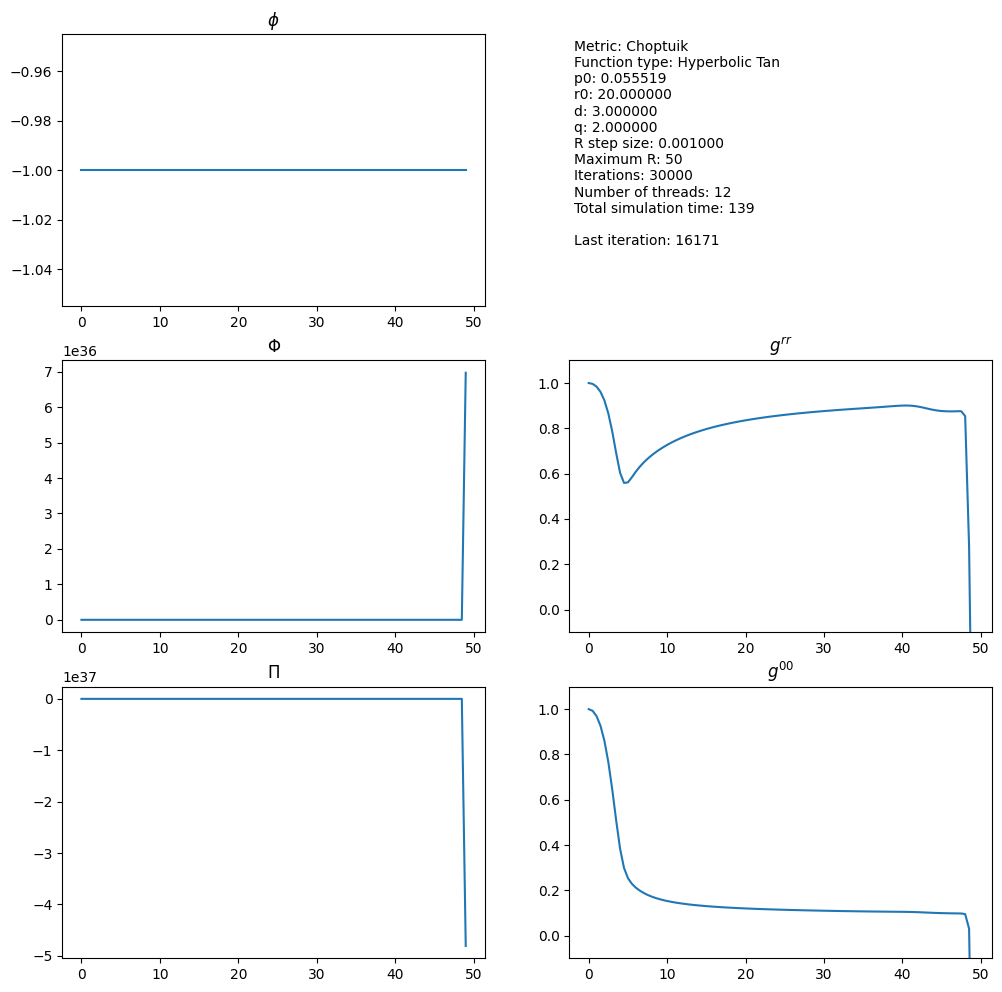

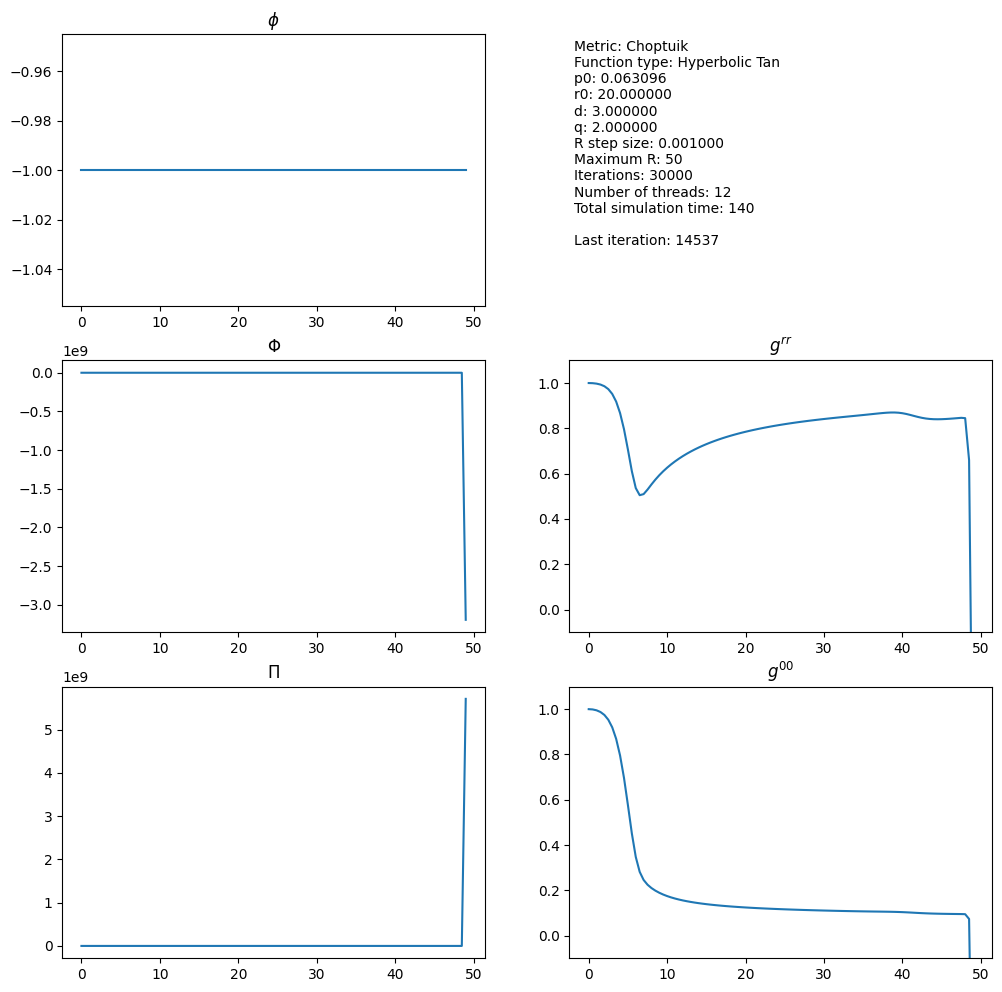

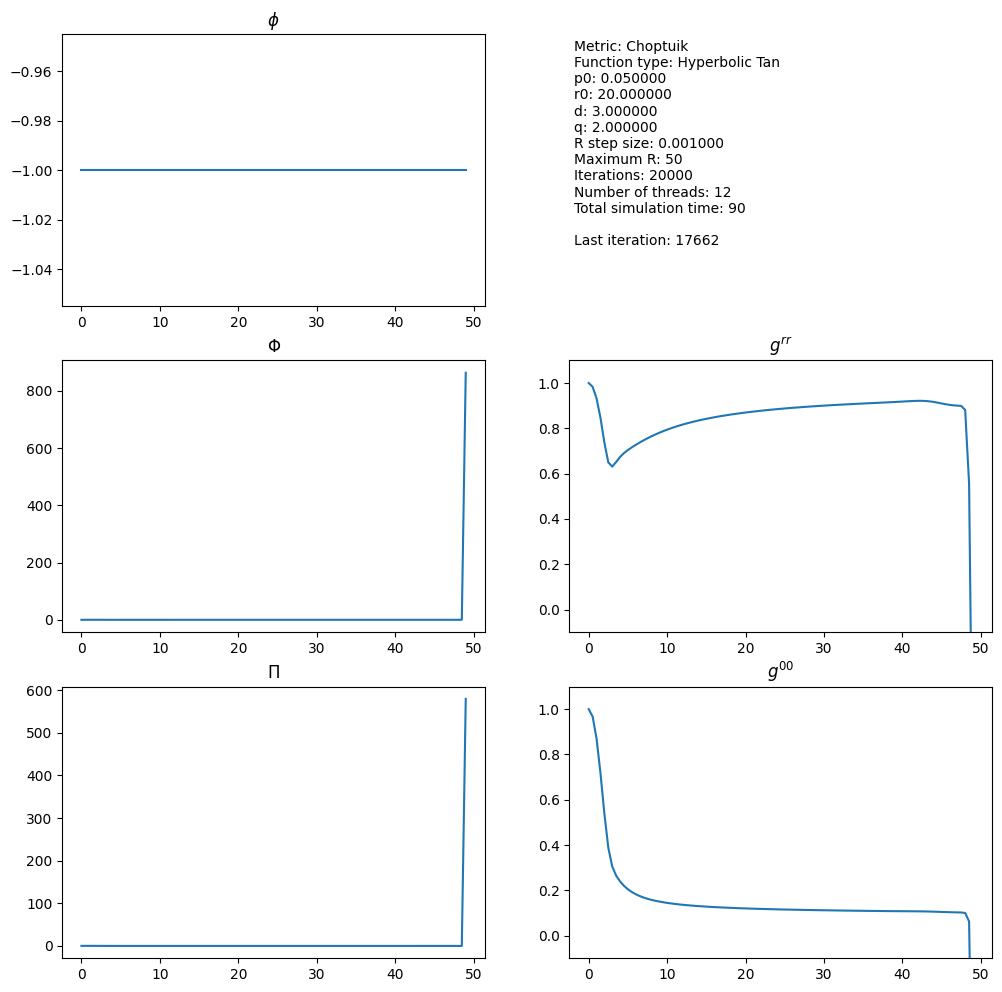

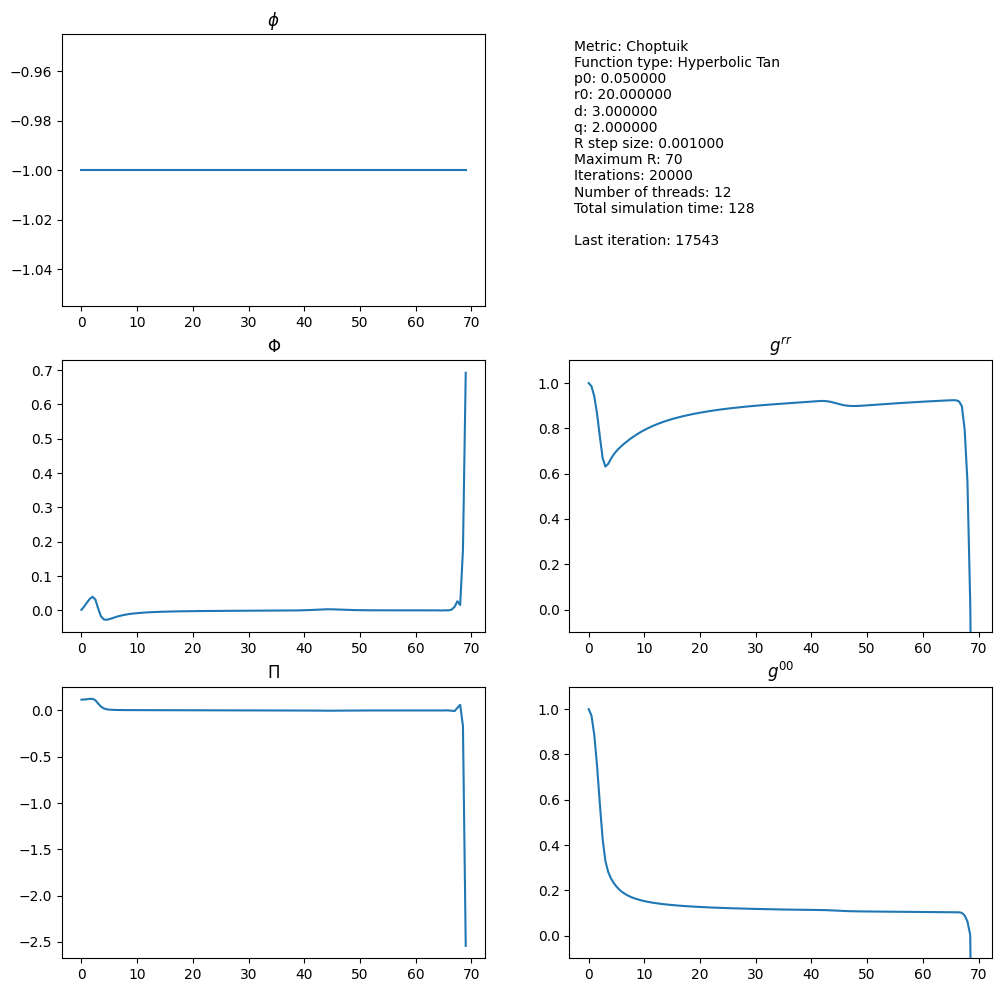

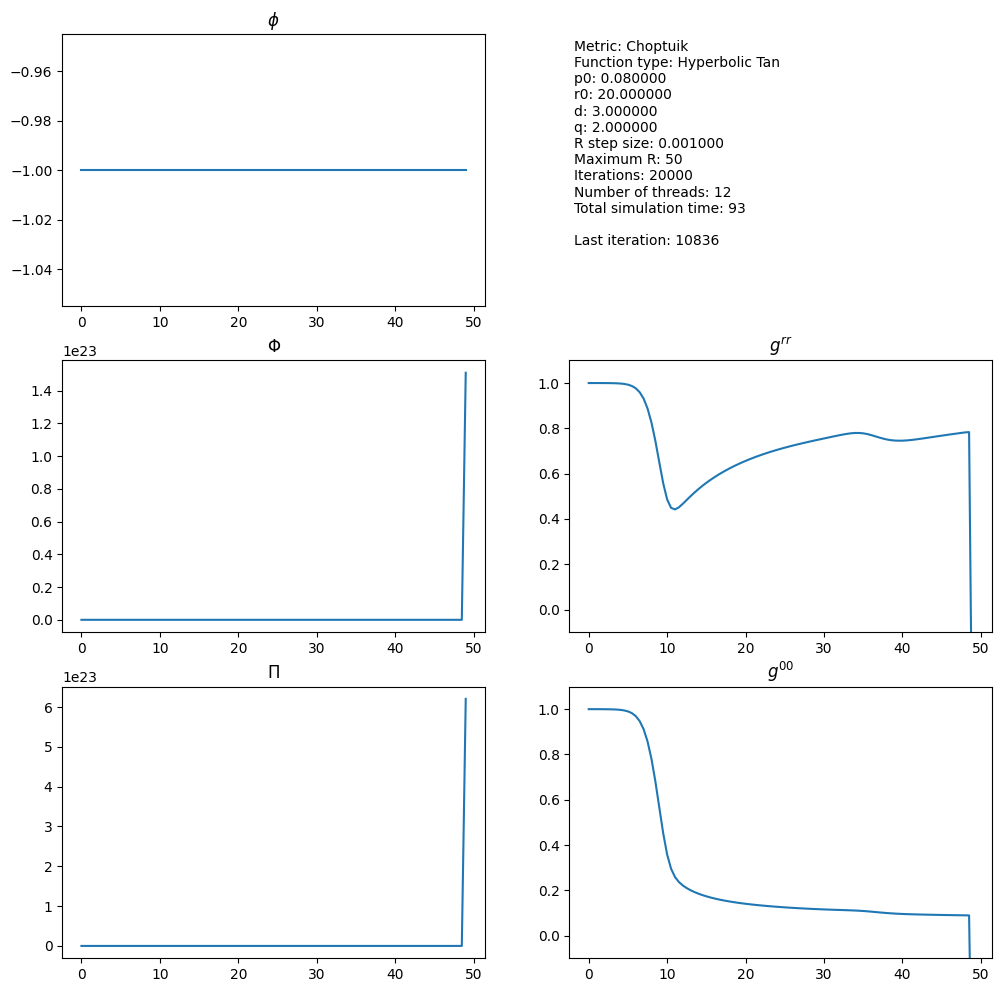

In [33]:
#Read the last runs and print the image before collapse
import pandas as pd
from os import listdir

#Search files
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
    r,f,x,y,a,b,param = read_data(file)
    if param['fType'] == 'Hyperbolic Tan':
        plot_last(file,0)
        plt.show()

In [5]:
#Run for exponential  function

import subprocess
import numpy as np

fType = "1"
p0s = np.array((3.7,5,6,8))*10**(-6)
r0 = "0"
d  = "0"
q  = "0"
iterations = "20000"
maxR = "50"
processes = "0"
for p0 in p0s:
    output = subprocess.check_output([".\Collapse_full.exe", fType, str(p0), r0, d, q, maxR, iterations, processes], text=True,)
    print(f"{output}")

Parallel execution:
Total iterations: 20000
Finished

Parallel execution:
Total iterations: 20000
Finished

Parallel execution:
Total iterations: 20000
Finished

Parallel execution:
Total iterations: 20000
Finished



In [1]:
#Read the last runs and print the image before collapse
import pandas as pd
from os import listdir

#Search files
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
    r,f,x,y,a,b,param = read_data(file)
    if param['fType'] == 'Exponential':
        plot_last(file,0)
        plt.show()

NameError: name 'read_data' is not defined

# Specific tests

## Minkowski test

In [4]:
# Test for gaussian curve

import subprocess
import numpy as np

fType = "1"
r0 = "0"
ds  = ["1","3","5"]
deltaR = '0.001'
maxR = "50"
iterations = "200000"
p0s = ['0.000001','0.000005','0.00001']

for d in ds:
    for p0 in p0s:
        output = subprocess.check_output([".\Collapse_minkowski.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")

Total iterations: 200000
Finished, total time: 254s

Total iterations: 200000
Finished, total time: 244s

Total iterations: 200000
Finished, total time: 244s

Total iterations: 200000
Finished, total time: 227s

Total iterations: 200000
Finished, total time: 232s

Total iterations: 200000
Finished, total time: 224s

Total iterations: 200000
Finished, total time: 225s

Total iterations: 200000
Finished, total time: 231s

Total iterations: 200000
Finished, total time: 224s



In [5]:
# Test for tanh curve

import subprocess
import numpy as np

fType = "0"
r0 = "0"
ds  = ['1','3','5']
deltaR = '0.001'
maxR = "50"
iterations = "200000"
p0s = ['0.01','0.05','0.1']

for d in ds:
    for p0 in p0s:
        output = subprocess.check_output([".\Collapse_minkowski.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")

Total iterations: 200000
Finished, total time: 219s

Total iterations: 200000
Finished, total time: 223s

Total iterations: 200000
Finished, total time: 220s

Total iterations: 200000
Finished, total time: 219s

Total iterations: 200000
Finished, total time: 221s

Total iterations: 200000
Finished, total time: 219s

Total iterations: 200000
Finished, total time: 223s

Total iterations: 200000
Finished, total time: 226s

Total iterations: 200000
Finished, total time: 222s



## Flat field test

In [8]:
# Test for tanh curve

import subprocess
import numpy as np

fType = '2'
r0 = '0'
d  = '0'
deltaR = '0.001'
maxR = "50"
iterations = "200000"
p0 = '1'

output = subprocess.check_output([".\Collapse.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
print(f"{output}")

Total iterations: 200000
Finished, total time: 2225s



## Schwarzschild radius test

In [1]:
# Test for gaussian curve

import subprocess
import numpy as np

fType = "1"
r0 = "0"
ds  = ['3','3.5','4.0','4.5']
deltaR = '0.001'
maxR = "50"
iterations = "400000"
p0s = ['0.000004','0.000006','0.000008','0.00001']

for d in ds:
    for p0 in p0s:
        output = subprocess.check_output([".\Collapse.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")

Total iterations: 400000
Finished, total time: 2737s

Total iterations: 400000
Finished, total time: 2872s

Total iterations: 400000
Finished, total time: 3105s

Total iterations: 400000
Finished, total time: 3596s

Total iterations: 400000
Finished, total time: 4262s

Total iterations: 400000
Finished, total time: 2429s

Total iterations: 400000
Finished, total time: 2952s

Total iterations: 400000
Finished, total time: 3543s

Total iterations: 400000
Finished, total time: 4261s

Total iterations: 400000
Finished, total time: 2608s

Total iterations: 400000
Finished, total time: 2963s

Total iterations: 400000
Finished, total time: 3538s

Total iterations: 400000
Finished, total time: 4405s

Total iterations: 400000
Finished, total time: 3326s

Total iterations: 400000
Finished, total time: 3088s

Total iterations: 400000
Finished, total time: 3676s



In [2]:
# Test for tanh curve

import subprocess
import numpy as np

fType = "0"
r0 = "0"
ds  = ['3','3.5','4.0']
deltaR = '0.001'
maxR = "50"
iterations = "400000"
p0s = ['0.04','0.06','0.08','0.1']

for d in ds:
    for p0 in p0s:
        output = subprocess.check_output([".\Collapse.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")

Total iterations: 400000
Finished, total time: 4391s

Total iterations: 400000
Finished, total time: 3985s

Total iterations: 400000
Finished, total time: 3859s

Total iterations: 400000
Finished, total time: 4508s

Total iterations: 400000
Finished, total time: 4567s

Total iterations: 400000
Finished, total time: 3682s

Total iterations: 400000
Finished, total time: 4544s

Total iterations: 400000
Finished, total time: 4488s

Total iterations: 400000
Finished, total time: 4294s

Total iterations: 400000
Finished, total time: 4271s

Total iterations: 400000
Finished, total time: 4273s

Total iterations: 400000
Finished, total time: 4190s



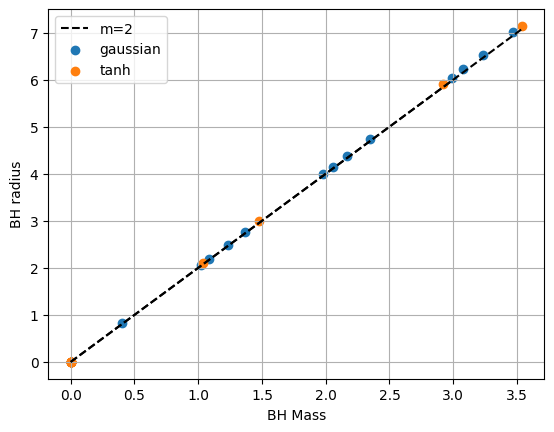

In [9]:
critical_p0 = 1.9154831466382175e-06
critical_radius = 0.078
critical_mass = 0.03925

from scipy.stats import linregress

#Get all radius and p0
from os import listdir
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
#Sort by modification date
folder_files.sort(key=getmtime)

tanh_df = pd.DataFrame(columns=['Radius','Mass','phi0'])
gauss_df = pd.DataFrame(columns=['Radius','Mass','phi0'])
for i, file in enumerate(folder_files):
    #Get parameters from the simulation
    mass0 = 1
    BHradius = read_params(file)['BH radius']
    BHmass = read_params(file)['BH mass']
    phi0 = read_params(file)['p0']
    #Add values to the dataframe
    new_row = pd.DataFrame([[BHradius,BHmass,phi0,mass0]],columns=['BHRadius','BHMass','phi0','Mass0'])
    if read_params(file)['fType'] == 'Exponential':
        gauss_df = pd.concat((gauss_df,new_row),ignore_index=True)
    if read_params(file)['fType'] == 'Hyperbolic Tan':
        tanh_df = pd.concat((tanh_df,new_row),ignore_index=True)
#Plot log(delta r0) vs log(delta phi0)
gauss_mass = gauss_df['BHMass'].values
gauss_mass_frac = gauss_df['BHMass'].values/gauss_df['Mass0'].values
gauss_radius = gauss_df['BHRadius'].values
tanh_mass = tanh_df['BHMass'].values
tanh_mass_frac = tanh_df['BHMass'].values/tanh_df['Mass0'].values
tanh_radius = tanh_df['BHRadius'].values

plt.plot((0,gauss_mass[-1]),(0,2*gauss_mass[-1]),'--k',label='m=2')
plt.plot((0,tanh_mass[-1]),(0,2*tanh_mass[-1]),'--k')
plt.scatter(gauss_mass,gauss_radius,label='gaussian')
plt.scatter(tanh_mass,tanh_radius,label='tanh')
plt.ylabel('BH radius')
plt.xlabel('BH Mass')
plt.legend()
plt.grid()
plt.show()

# Comparative tests

## Uniform grid tests

In [8]:
#Full normal uniform iteration

import subprocess
import numpy as np

fType = "1"
p0s = ['0.000004','0.0000045','0.0000055','0.000007']
r0 = "0"
d  = "0"
#deltaRs = ['0.0005','0.001','0.002','0.004']
deltaRs = ['0.008','0.016','0.032']
maxR = "50"
#iterations = "600000"
iterations = "50000"


for deltaR in deltaRs:
    for p0 in p0s:
        output = subprocess.check_output([".\Collapse.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")
        animate_data(output_name='UniformFull.gif',ipf=10)

Total iterations: 50000
Finished, total time: 34s

Total iterations: 50000
Finished, total time: 39s

Total iterations: 50000
Finished, total time: 35s

Total iterations: 50000
Finished, total time: 41s

Total iterations: 50000
Finished, total time: 9s

Total iterations: 50000
Finished, total time: 10s

Total iterations: 50000
Finished, total time: 9s

Total iterations: 50000
Finished, total time: 11s

Total iterations: 50000
Finished, total time: 15s

Total iterations: 50000
Finished, total time: 3s

Total iterations: 50000
Finished, total time: 5s

Total iterations: 50000
Finished, total time: 5s



In [9]:
#Quasi-static uniform iteration

import subprocess
import numpy as np

fType = "1"
p0s = ['0.000004','0.0000045','0.0000055','0.000007']
r0 = "0"
d  = "0"
#deltaRs = ['0.0005','0.001','0.002','0.004']
deltaRs = ['0.00025','0.008','0.016','0.032']
maxR = "50"
iterations = "1200000"


for deltaR in deltaRs:
    for p0 in p0s:
        output = subprocess.check_output([".\CollapseQS.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")
        animate_data(output_name='UniformQS.gif',ipf=10)

Total iterations: 1200000
Finished, total time: 15660s

Total iterations: 1200000
Finished, total time: 17926s

Total iterations: 1200000
Finished, total time: 16057s

Total iterations: 1200000
Finished, total time: 19376s

Total iterations: 1200000
Finished, total time: 11s

Total iterations: 1200000
Finished, total time: 13s

Total iterations: 1200000
Finished, total time: 11s

Total iterations: 1200000
Finished, total time: 13s

Total iterations: 1200000
Finished, total time: 3s

Total iterations: 1200000
Finished, total time: 3s

Total iterations: 1200000
Finished, total time: 3s

Total iterations: 1200000
Finished, total time: 3s

Total iterations: 1200000
Finished, total time: 1s

Total iterations: 1200000
Finished, total time: 1s

Total iterations: 1200000
Finished, total time: 2s

Total iterations: 1200000
Finished, total time: 1s



## Variable grid tests

In [10]:
#Variable local metric iteration grid arrangement A with 4 subgrids

import subprocess
import numpy as np

fType = "1"
p0s = ['0.000004','0.0000045','0.0000055','0.000007']
r0 = "0"
d  = "0"
#deltaRs = ['0.004','0.008','0.016','0.032']
deltaRs = ['0.002','0.064','0.128','0.256']
maxR = "50"
#iterations = "75000"
iterations = "150000"

for deltaR in deltaRs:
    for p0 in p0s:
        output = subprocess.check_output([".\VCollapseLocalA.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")
        animate_data(output_name='VariableLocalA.gif',ipf=1)

Total iterations: 150000
nR: 25001
nR_extended: 25001
dR_pointer: 0.002000
dT_pointer: 0.000400
grid range: 1.000000e-50 - 5.000000e+01

nR: 12501
nR_extended: 12517
dR_pointer: 0.002000
dT_pointer: 0.000400
grid range: 2.500000e+01 - 5.000000e+01

nR: 12501
nR_extended: 12533
dR_pointer: 0.001000
dT_pointer: 0.000200
grid range: 1.250000e+01 - 2.500000e+01

nR: 12501
nR_extended: 12533
dR_pointer: 0.000500
dT_pointer: 0.000100
grid range: 6.250000e+00 - 1.250000e+01

nR: 25001
nR_extended: 25017
dR_pointer: 0.000250
dT_pointer: 0.000050
grid range: 1.000000e-50 - 6.250000e+00

Finished, total time: 2406s

Total iterations: 150000
nR: 25001
nR_extended: 25001
dR_pointer: 0.002000
dT_pointer: 0.000400
grid range: 1.000000e-50 - 5.000000e+01

nR: 12501
nR_extended: 12517
dR_pointer: 0.002000
dT_pointer: 0.000400
grid range: 2.500000e+01 - 5.000000e+01

nR: 12501
nR_extended: 12533
dR_pointer: 0.001000
dT_pointer: 0.000200
grid range: 1.250000e+01 - 2.500000e+01

nR: 12501
nR_extended: 12

In [11]:
#Variable local metric iteration grid arrangement B with 4 subgrids

import subprocess
import numpy as np

fType = "1"
p0s = ['0.000004','0.0000045','0.0000055','0.000007']
r0 = "0"
d  = "0"
#deltaRs = ['0.004','0.008','0.016','0.032']
deltaRs = ['0.002','0.064','0.128','0.256']
maxR = "50"
#iterations = "75000"
iterations = "150000"

for deltaR in deltaRs:
    for p0 in p0s:
        output = subprocess.check_output([".\VCollapseLocalB4.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")
        animate_data(output_name='VariableLocalB4.gif',ipf=1)

Total iterations: 150000
nR: 25001
nR_extended: 25001
dR_pointer: 0.002000
dT_pointer: 0.000400
grid range: 1.000000e-50 - 5.000000e+01

nR: 6251
nR_extended: 6267
dR_pointer: 0.002000
dT_pointer: 0.000400
grid range: 3.750000e+01 - 5.000000e+01

nR: 12501
nR_extended: 12533
dR_pointer: 0.001000
dT_pointer: 0.000200
grid range: 2.500000e+01 - 3.750000e+01

nR: 25001
nR_extended: 25033
dR_pointer: 0.000500
dT_pointer: 0.000100
grid range: 1.250000e+01 - 2.500000e+01

nR: 50001
nR_extended: 50017
dR_pointer: 0.000250
dT_pointer: 0.000050
grid range: 1.000000e-50 - 1.250000e+01

Finished, total time: 4395s

Total iterations: 150000
nR: 25001
nR_extended: 25001
dR_pointer: 0.002000
dT_pointer: 0.000400
grid range: 1.000000e-50 - 5.000000e+01

nR: 6251
nR_extended: 6267
dR_pointer: 0.002000
dT_pointer: 0.000400
grid range: 3.750000e+01 - 5.000000e+01

nR: 12501
nR_extended: 12533
dR_pointer: 0.001000
dT_pointer: 0.000200
grid range: 2.500000e+01 - 3.750000e+01

nR: 25001
nR_extended: 25033


In [12]:
#Variable local metric iteration grid arrangement B with 6 grids

import subprocess
import numpy as np

fType = "1"
p0s = ['0.000004','0.0000045','0.0000055','0.000007']
r0 = "0"
d  = "0"
#deltaRs = ['0.016','0.032','0.064','0.128']
deltaRs = ['0.008','0.256','0.512','1.024']
maxR = "50"
#iterations = "18750"
iterations = "37500"

for deltaR in deltaRs:
    for p0 in p0s:
        output = subprocess.check_output([".\VCollapseLocalB6.exe",  fType, p0, r0, d, deltaR, maxR, iterations], text=True,)
        print(f"{output}")
        animate_data(output_name='VariableLocalB6.gif',ipf=1)

Total iterations: 37500
nR: 6251
nR_extended: 6251
dR_pointer: 0.008000
dT_pointer: 0.001600
grid range: 1.000000e-50 - 5.000000e+01

nR: 1042
nR_extended: 1058
dR_pointer: 0.008000
dT_pointer: 0.001600
grid range: 4.166667e+01 - 4.999467e+01

nR: 2084
nR_extended: 2116
dR_pointer: 0.004000
dT_pointer: 0.000800
grid range: 3.333333e+01 - 4.166533e+01

nR: 4167
nR_extended: 4199
dR_pointer: 0.002000
dT_pointer: 0.000400
grid range: 2.500000e+01 - 3.333200e+01

nR: 8334
nR_extended: 8366
dR_pointer: 0.001000
dT_pointer: 0.000200
grid range: 1.666667e+01 - 2.499967e+01

nR: 16667
nR_extended: 16699
dR_pointer: 0.000500
dT_pointer: 0.000100
grid range: 8.333333e+00 - 1.666633e+01

nR: 33334
nR_extended: 33350
dR_pointer: 0.000250
dT_pointer: 0.000050
grid range: 1.000000e-50 - 8.333250e+00

Finished, total time: 3121s

Total iterations: 37500
nR: 6251
nR_extended: 6251
dR_pointer: 0.008000
dT_pointer: 0.001600
grid range: 1.000000e-50 - 5.000000e+01

nR: 1042
nR_extended: 1058
dR_pointer: 

C:\Users\bigba\AppData\Local\Temp\ipykernel_20344\1429952132.py:85: RuntimeWarning: divide by zero encountered in power
  grdata = (np.array(alldata[4*len_6:5*len_6]))**(-2)


Total iterations: 37500
nR: 49
nR_extended: 49
dR_pointer: 1.024000
dT_pointer: 0.204800
grid range: 1.000000e-50 - 4.915200e+01

nR: 9
nR_extended: 25
dR_pointer: 1.024000
dT_pointer: 0.204800
grid range: 4.166667e+01 - 4.985867e+01

nR: 17
nR_extended: 49
dR_pointer: 0.512000
dT_pointer: 0.102400
grid range: 3.333333e+01 - 4.152533e+01

nR: 33
nR_extended: 65
dR_pointer: 0.256000
dT_pointer: 0.051200
grid range: 2.500000e+01 - 3.319200e+01

nR: 66
nR_extended: 98
dR_pointer: 0.128000
dT_pointer: 0.025600
grid range: 1.666667e+01 - 2.498667e+01

nR: 131
nR_extended: 163
dR_pointer: 0.064000
dT_pointer: 0.012800
grid range: 8.333333e+00 - 1.665333e+01

nR: 261
nR_extended: 277
dR_pointer: 0.032000
dT_pointer: 0.006400
grid range: 1.000000e-50 - 8.320000e+00

Finished, total time: 0s



C:\Users\bigba\AppData\Local\Temp\ipykernel_20344\1429952132.py:85: RuntimeWarning: divide by zero encountered in power
  grdata = (np.array(alldata[4*len_6:5*len_6]))**(-2)


Total iterations: 37500
nR: 49
nR_extended: 49
dR_pointer: 1.024000
dT_pointer: 0.204800
grid range: 1.000000e-50 - 4.915200e+01

nR: 9
nR_extended: 25
dR_pointer: 1.024000
dT_pointer: 0.204800
grid range: 4.166667e+01 - 4.985867e+01

nR: 17
nR_extended: 49
dR_pointer: 0.512000
dT_pointer: 0.102400
grid range: 3.333333e+01 - 4.152533e+01

nR: 33
nR_extended: 65
dR_pointer: 0.256000
dT_pointer: 0.051200
grid range: 2.500000e+01 - 3.319200e+01

nR: 66
nR_extended: 98
dR_pointer: 0.128000
dT_pointer: 0.025600
grid range: 1.666667e+01 - 2.498667e+01

nR: 131
nR_extended: 163
dR_pointer: 0.064000
dT_pointer: 0.012800
grid range: 8.333333e+00 - 1.665333e+01

nR: 261
nR_extended: 277
dR_pointer: 0.032000
dT_pointer: 0.006400
grid range: 1.000000e-50 - 8.320000e+00

Finished, total time: 1s



C:\Users\bigba\AppData\Local\Temp\ipykernel_20344\1429952132.py:85: RuntimeWarning: divide by zero encountered in power
  grdata = (np.array(alldata[4*len_6:5*len_6]))**(-2)


Total iterations: 37500
nR: 49
nR_extended: 49
dR_pointer: 1.024000
dT_pointer: 0.204800
grid range: 1.000000e-50 - 4.915200e+01

nR: 9
nR_extended: 25
dR_pointer: 1.024000
dT_pointer: 0.204800
grid range: 4.166667e+01 - 4.985867e+01

nR: 17
nR_extended: 49
dR_pointer: 0.512000
dT_pointer: 0.102400
grid range: 3.333333e+01 - 4.152533e+01

nR: 33
nR_extended: 65
dR_pointer: 0.256000
dT_pointer: 0.051200
grid range: 2.500000e+01 - 3.319200e+01

nR: 66
nR_extended: 98
dR_pointer: 0.128000
dT_pointer: 0.025600
grid range: 1.666667e+01 - 2.498667e+01

nR: 131
nR_extended: 163
dR_pointer: 0.064000
dT_pointer: 0.012800
grid range: 8.333333e+00 - 1.665333e+01

nR: 261
nR_extended: 277
dR_pointer: 0.032000
dT_pointer: 0.006400
grid range: 1.000000e-50 - 8.320000e+00

Finished, total time: 0s



C:\Users\bigba\AppData\Local\Temp\ipykernel_20344\1429952132.py:85: RuntimeWarning: divide by zero encountered in power
  grdata = (np.array(alldata[4*len_6:5*len_6]))**(-2)


## Results comparison

In [90]:
#folder = 'Comparative test'

from os import listdir
import pandas as pd

#Animation in paralel of scalar fields
def compare_multiple(folder):

    #Read all files from folder
    folder = '.\\'+folder
    folder_files = listdir(folder)
    folder_files = [f for f in folder_files if f.endswith('.dat')]
    df = pd.DataFrame(columns=['Type','BH radius','BH mass','phi0','deltaR',
                               'Time','Iterations','Simulated time'])
    for file in folder_files:
        data = read_params(folder+'\\'+file)
        runtype_dict = {'Variable Choptuik A':'VariableA',
                        'Variable Choptuik B':'VariableB',
                        'Quasi-Static Choptuik':'UniformQS',
                        'Modified Choptuik':'UniformQS',
                        'Choptuik':'Uniform'}
        run_type = runtype_dict[data['metric']]
        if run_type.startswith('Variable'):
            run_type += str(data['grids'])
        BHradius = data['BH radius']
        BHmass = data['BH mass']
        phi0 = data['p0']
        deltaR = data['deltaR']*(2**(1-data['grids']))
        time = data['time']
        iterations = data['iterations']
        sim_time = iterations*data['deltaR']

        new_row = pd.DataFrame([[run_type,BHradius,BHmass,phi0,deltaR,time,iterations,sim_time]],
                               columns=['Type','BH radius','BH mass','phi0','deltaR',
                                        'Time','Iterations','Simulated time'])
        df = pd.concat((df,new_row),ignore_index=True)
    
    df = df.sort_values(by=['Type','deltaR','phi0'],ignore_index=True)

    return df

def MR_plot(MR_dataframe,hue=None):

    mass = MR_dataframe['BH mass'].values
    radius = MR_dataframe['BH radius'].values

    plt.scatter(mass,radius)
    plt.ylabel('BH radius')
    plt.xlabel('BH Mass')
    plt.plot((0,mass[-1]),(0,2*mass[-1]),'-r',label='m=2')
    plt.legend()
    plt.grid()
    plt.show()

def Compare_plot(data,param='BH radius',maxdR=1,mindR=0):

    df = data.copy()
    df = df[df['deltaR']>=mindR]
    df = df[df['deltaR']<=maxdR]
    phi0s  = pd.unique(df['phi0'].values)
    types  = pd.unique(df['Type'].values)
    deltaRs  = pd.unique(df['deltaR'].values)

    Nplots = len(pd.unique(phi0s))
    fig, ax = plt.subplots(Nplots,1,sharey=True, figsize=(4,2*Nplots),dpi=200)
    #plt.yscale('log')

    for i in range(Nplots):
        phi0 = phi0s[i]
        #plot result parameter (eg: radius) in x axis
        #plot deltaR in common y axis
        #seprate color by runtype
        df1 = df[df['phi0']==phi0]
        for it,t in enumerate(types):
            df2 = df1[df1['Type']==t]
            if t == 'Uniform':
                ax[i].plot(df2[param],df2['deltaR'],marker='o',ms=10,ls='--',lw=0.8,alpha=1)
            else:
                ax[i].plot(df2[param],df2['deltaR'],marker=3+it,ms=5,ls=':',lw=0.8,alpha=1)
        ax[i].set_xlabel(f'$\phi_0$={phi0}')
        ax[i].set_yscale('log')
        ax[i].minorticks_off()
        ax[i].set_yticks(deltaRs)
        ax[i].set_yticklabels(deltaRs)
    fig.legend(types,loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.show()

def Compare_time(df,param='Time'):

    phi0s  = pd.unique(df['phi0'].values)
    types  = pd.unique(df['Type'].values)
    deltaRs  = pd.unique(df['deltaR'].values)

    fig, ax = plt.subplots(1,1,sharey=True, figsize=(4,2),dpi=200)
    #plt.yscale('log')

    #plot result parameter (eg: radius) in x axis
    #plot deltaR in common y axis
    #seprate color by runtype
    for it,t in enumerate(types):
        df2 = df[df['Type']==t]
        if t == 'Uniform':
            ax.plot(df2[param],df2['deltaR'],marker='o',ms=10,ls='--',lw=0.8,alpha=1)
        else:
            ax.plot(df2[param],df2['deltaR'],marker=3+it,ms=5,ls=':',lw=0.8,alpha=1)
    ax.set_yscale('log')
    ax.minorticks_off()
    ax.set_yticks(deltaRs)
    ax.set_yticklabels(deltaRs)
    fig.legend(types,loc='upper center', bbox_to_anchor=(0.5, 1))
    fig.tight_layout()
    plt.show()



In [108]:
dataf = compare_multiple('Comparative test')

data1 = dataf[dataf['deltaR']==0.0005]
data1[data1['phi0']==0.0000045]
#data1

,Type,BH radius,BH mass,phi0,deltaR,Time,Iterations,Simulated time
1,Uniform,1.4330,0.709463,0.000005,0.0005,10998,476555,238.2775
33,UniformQS,1.4330,0.709464,0.000005,0.0005,3843,476556,238.2780
65,VariableA4,1.4325,0.709093,0.000005,0.0005,707,59569,238.2760
97,VariableB4,1.4330,0.709341,0.000005,0.0005,1373,59572,238.2880
129,VariableB6,1.4325,0.709093,0.000005,0.0005,768,14898,238.3680


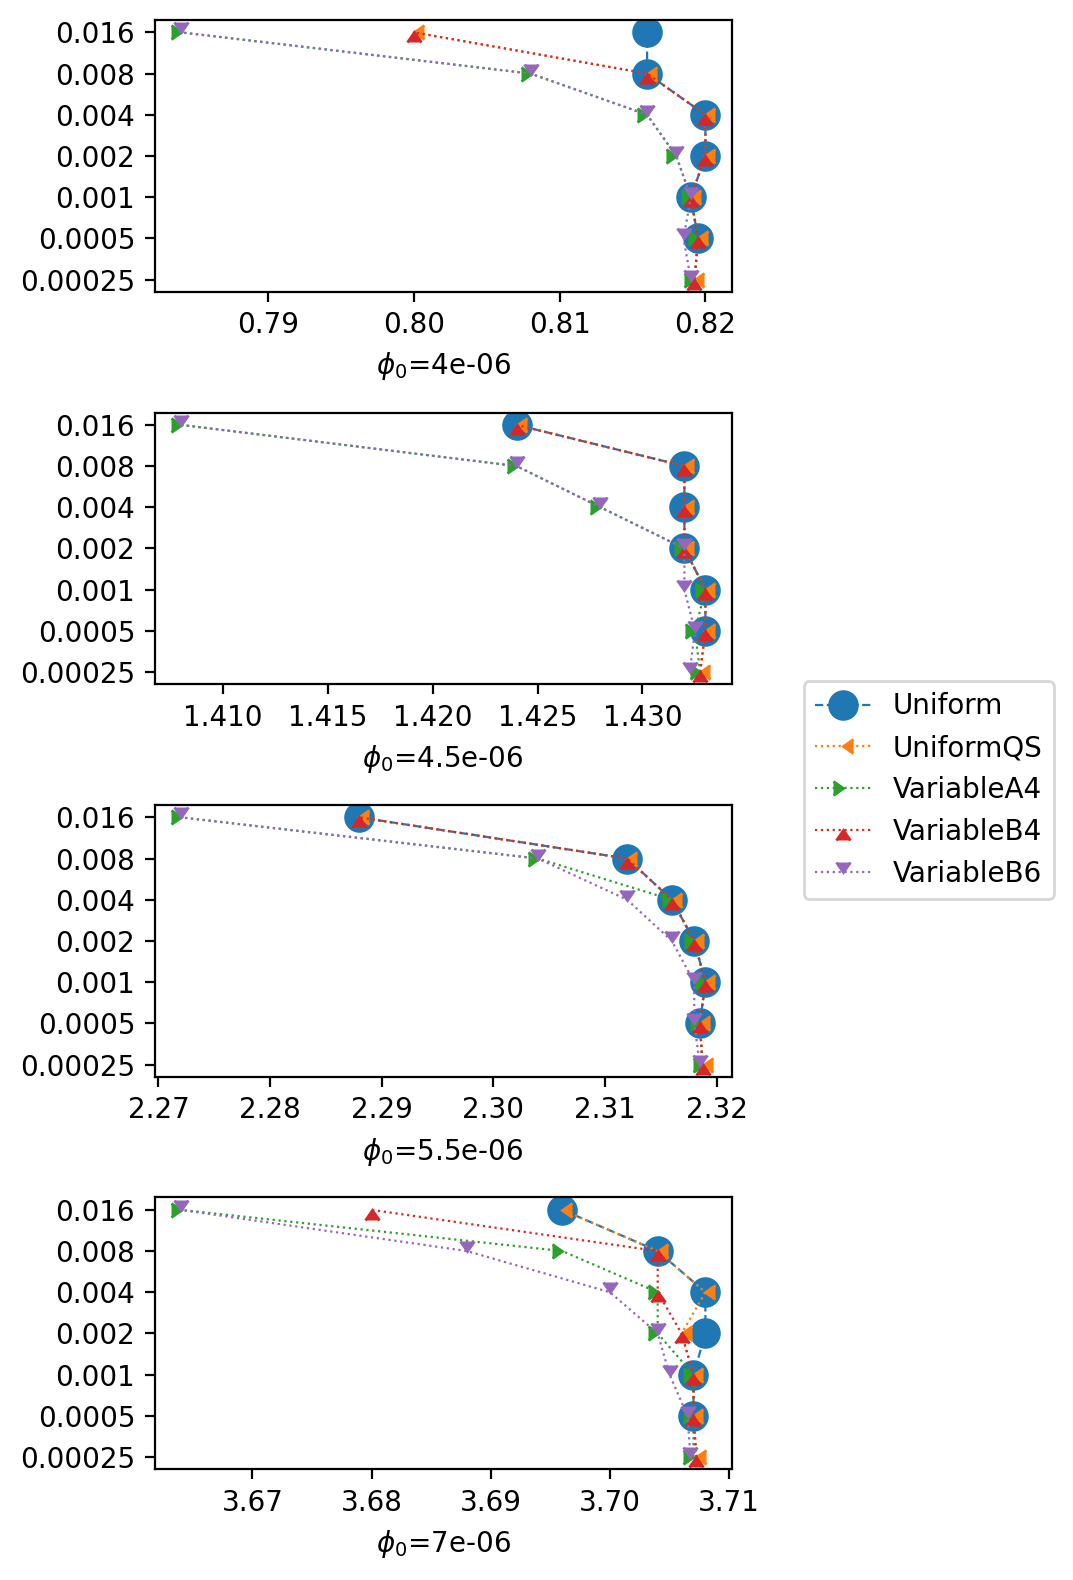

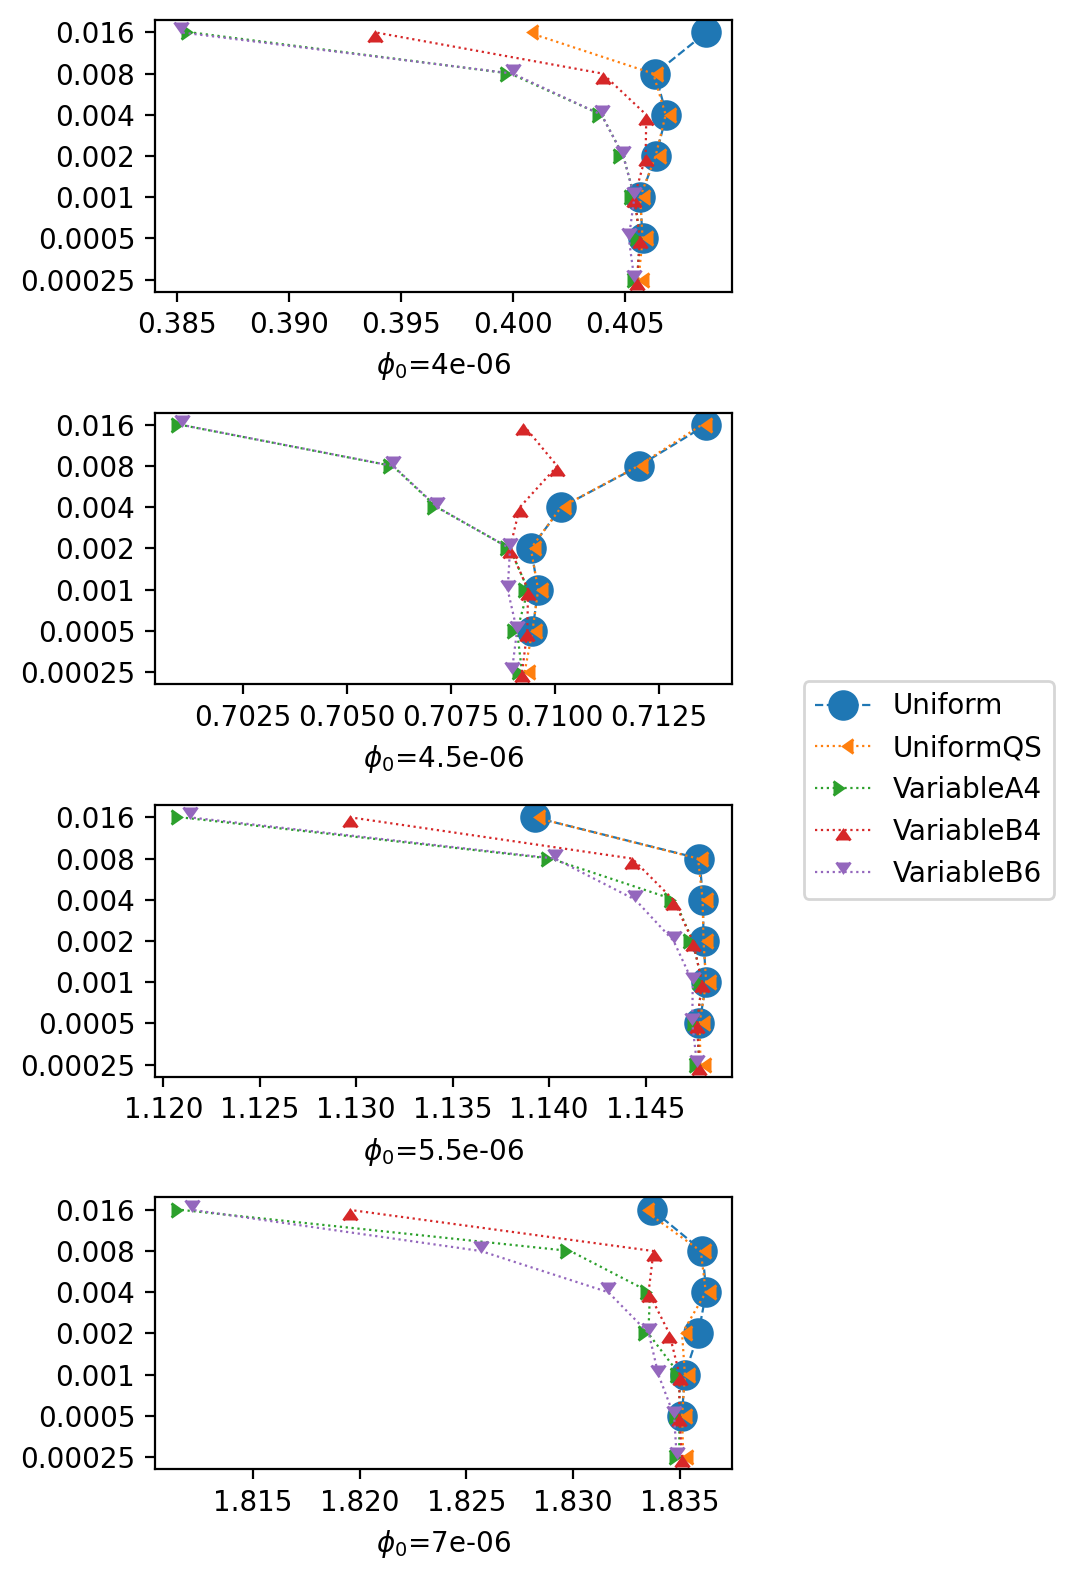

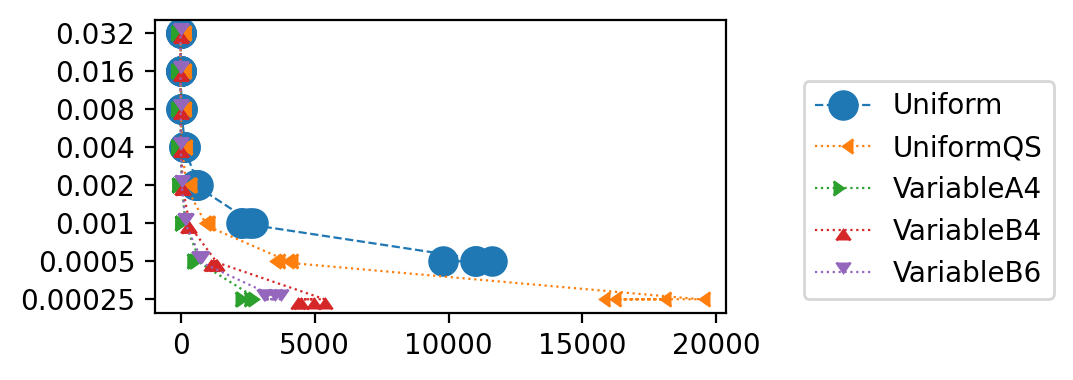

In [8]:
folder = 'Comparative test'

dataf = compare_multiple(folder)

dataf

Compare_plot(dataf,maxdR=0.02)
Compare_plot(dataf,param='BH mass',maxdR=0.02)
Compare_time(dataf)

#pd.unique(dataf['Type'])

# Fig 1 replica

In [2]:
#Run the simulation

import subprocess
output = subprocess.check_output([".\Collapse.exe", '0', '0.04', '0', '0', '0', '0.01', '100', '21000'], text=True,)
#output = subprocess.check_output([".\Collapse_full.exe", '1', '0.00000016', '0', '0', '0', '50', '11'], text=True,)
print(f"Execution:\n{output}")

Execution:
Total iterations: 21000
Finished, total time: 44s



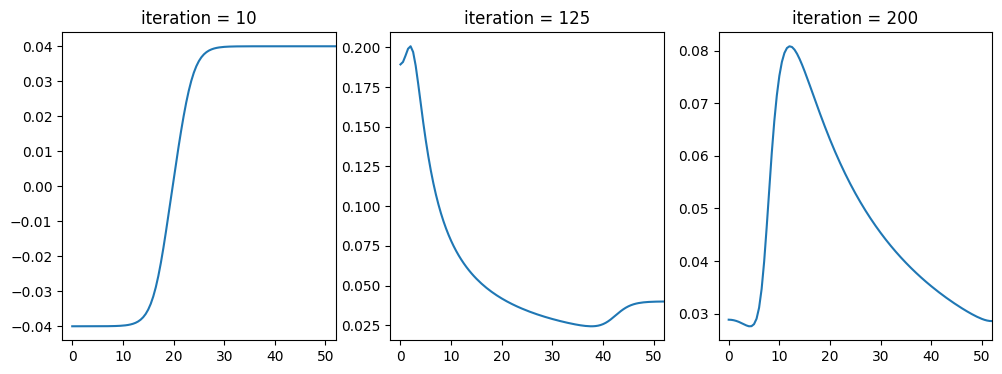

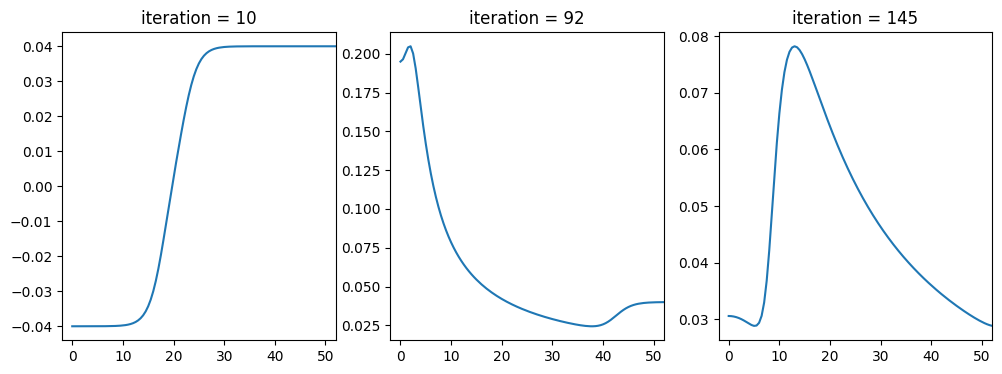

In [12]:
#Plot the phi field at given times

fname = 'Output_213901.dat'
r,f,x,y,a,b,param = read_data(fname)

tanh_times = [10,125,200]
fig, ax = plt.subplots(1,3,figsize=(12,4),dpi=100)
ax[0].plot(r,f[tanh_times[0]])[0]
ax[0].set_xlim(-2,52)
ax[0].set_title(f'iteration = {tanh_times[0]}')
ax[1].plot(r,f[tanh_times[1]])[0]
ax[1].set_xlim(-2,52)
ax[1].set_title(f'iteration = {tanh_times[1]}')
ax[2].plot(r,f[tanh_times[2]])[0]
ax[2].set_xlim(-2,52)
ax[2].set_title(f'iteration = {tanh_times[2]}')
plt.show()


fname = 'Output_214109.dat'
r,f,x,y,a,b,param = read_data(fname)

tanh_times = [10,92,145]
fig, ax = plt.subplots(1,3,figsize=(12,4),dpi=100)
ax[0].plot(r,f[tanh_times[0]])[0]
ax[0].set_xlim(-2,52)
ax[0].set_title(f'iteration = {tanh_times[0]}')
ax[1].plot(r,f[tanh_times[1]])[0]
ax[1].set_xlim(-2,52)
ax[1].set_title(f'iteration = {tanh_times[1]}')
ax[2].plot(r,f[tanh_times[2]])[0]
ax[2].set_xlim(-2,52)
ax[2].set_title(f'iteration = {tanh_times[2]}')
plt.show()

# Critical point 10^-2

In [4]:
#Find critical point
import subprocess
import numpy as np

#Define an initial known subcritical and supercritical parameter
sub_p0   = 3.828125e-06
super_p0 = 3.835937499999999e-06

#How many iterations to make to find the critical point
critical_iterations = 10

fType = "1"
r0 = "0"
d  = "0"
ko = "0"
deltaR = '0.01'
maxR = "50"
iterations = "50000"

for i in range(critical_iterations):
    new_p0 = sub_p0 + (super_p0 - sub_p0)/2
    print(f'Now trying p0 = {new_p0} ...')
    output = subprocess.check_output([".\Collapse.exe",  fType, str(new_p0), r0, d, ko, deltaR, maxR, iterations], text=True,)
    #Read last output and check if it has a non-zero radius
    last_radius = float(read_params()['BH radius'])
    #If BH has formed, save as new supercritical value
    if last_radius > 0.0:
        super_p0 = new_p0
        print('Parameter is supercritical\n')
    #If BH hasn't formed, save as new subcritical value
    elif last_radius == 0.0:
        sub_p0 = new_p0
        print('Parameter is subcritical\n')
print('Critical search result:')
print(f'Highest subcritical value is:  {sub_p0}')
print(f'Lowest supercritical value is: {super_p0}')



Now trying p0 = 3.8320312499999995e-06 ...
Parameter is subcritical

Now trying p0 = 3.833984374999999e-06 ...
Parameter is supercritical

Now trying p0 = 3.8330078125e-06 ...
Parameter is subcritical

Now trying p0 = 3.833496093749999e-06 ...
Parameter is supercritical

Now trying p0 = 3.833251953125e-06 ...
Parameter is subcritical

Now trying p0 = 3.8333740234375e-06 ...
Parameter is supercritical

Now trying p0 = 3.83331298828125e-06 ...
Parameter is supercritical

Now trying p0 = 3.833282470703125e-06 ...
Parameter is subcritical

Now trying p0 = 3.833297729492187e-06 ...
Parameter is supercritical

Now trying p0 = 3.833290100097656e-06 ...
Parameter is subcritical

Critical search result:
Highest subcritical value is:  3.833290100097656e-06
Lowest supercritical value is: 3.833297729492187e-06


In [4]:
#Make a bunch of runs with p0 higher than critical_p0

critical_p0 = 3.833297729492187e-06
critical_radius = 0.25
critical_mass = 0.121770
p0s = np.logspace(np.log10(1.001*critical_p0),np.log10(1.05*critical_p0),20)

fType = "1"
r0 = "0"
d  = "0"
ko = "0"
deltaR = "0.01"
maxR = "50"
iterations = "50000"

for p0 in p0s:
    output = subprocess.check_output([".\Collapse.exe",  fType, str(p0), r0, d, ko, deltaR, maxR, iterations], text=True,)



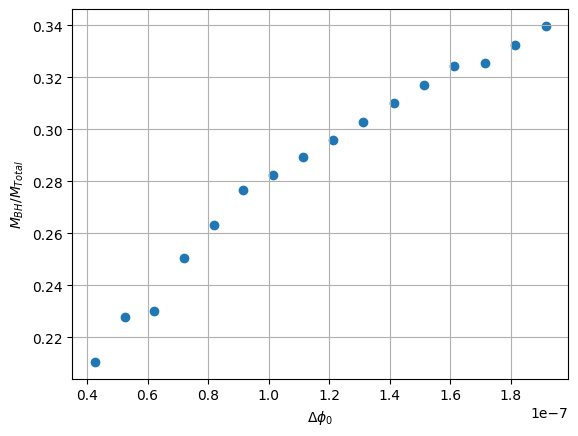

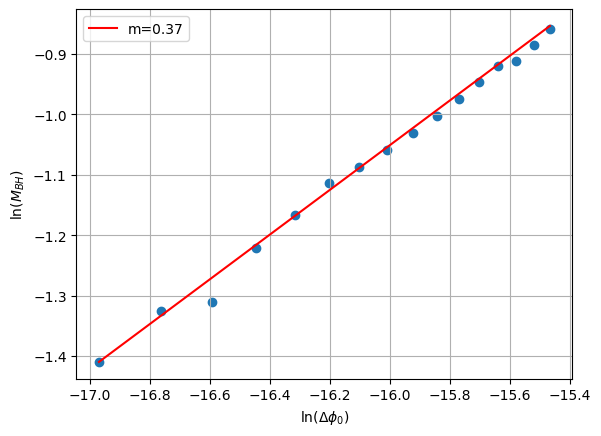

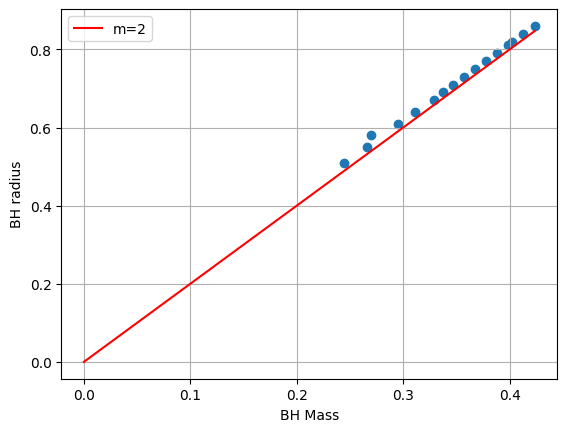

In [6]:
critical_p0 = 3.833297729492187e-06
critical_radius = 0.25
critical_mass = 0.121770

#Get all radius and p0
from os import listdir
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
#Sort by modification date
folder_files.sort(key=getmtime)

results_df = pd.DataFrame(columns=['BHRadius','BHMass','phi0','Mass0'])
for i, file in enumerate(folder_files):
    #Get parameters from the simulation
    BHradius = read_params(file)['BH radius']
    BHmass = read_params(file)['BH mass']
    phi0 = read_params(file)['p0']
    #phi0 = p0s[i]
    with open('Mass'+file[6:]) as f:
        mass0 = float(f.readline().split(',')[0]) 
    #Add values to the dataframe
    new_row = pd.DataFrame([[BHradius,BHmass,phi0,mass0]],columns=['BHRadius','BHMass','phi0','Mass0'])
    results_df = pd.concat((results_df,new_row),ignore_index=True)
#Plot log(delta r0) vs log(delta phi0)
mass = results_df['BHMass'].values
mass_frac = results_df['BHMass'].values/results_df['Mass0'].values
radius = results_df['BHRadius'].values
dphi = results_df['phi0'].values-critical_p0
log_dr   = np.log(results_df['BHRadius'].values-critical_radius)
log_dp = np.log(dphi)
log_mass = np.log(mass)

plt.scatter(dphi,mass_frac)
plt.ylabel('$M_{BH}/M_{Total}$')
plt.xlabel('$\Delta \phi_0$')
plt.grid()
plt.show()

plt.scatter(log_dp,log_mass)
plt.ylabel('ln($M_{BH}$)')
plt.xlabel('ln($\Delta \phi_0$)')
plt.plot((log_dp[0],log_dp[-1]),(log_mass[0],log_mass[0]+0.37*(log_dp[-1]-log_dp[0])),'-r',label='m=0.37')
plt.legend()
plt.grid()
plt.show()

plt.scatter(mass,radius)
plt.ylabel('BH radius')
plt.xlabel('BH Mass')
plt.plot((0,mass[-1]),(0,2*mass[-1]),'-r',label='m=2')
plt.legend()
plt.grid()
plt.show()

# Critical point 10^-3

In [14]:
#Find critical point
import subprocess
import numpy as np

#Define an initial known subcritical and supercritical parameter
sub_p0   = 1.9154793153311646e-06
super_p0 = 1.915494580928138e-06

#How many iterations to make to find the critical point
critical_iterations = 10

fType = "1"
r0 = "0"
d  = "0"
ko = "0"
deltaR = '0.001'
maxR = "50"
iterations = "500000"

for i in range(critical_iterations):
    new_p0 = sub_p0 + (super_p0 - sub_p0)/2
    print(f'Now trying p0 = {new_p0} ...')
    output = subprocess.check_output([".\Collapse.exe",  fType, str(new_p0), r0, d, ko, deltaR, maxR, iterations], text=True,)
    #Read last output and check if it has a non-zero radius
    last_radius = float(read_params()['BH radius'])
    #If BH has formed, save as new supercritical value
    if last_radius > 0.0:
        super_p0 = new_p0
        print('Parameter is supercritical\n')
    #If BH hasn't formed, save as new subcritical value
    elif last_radius == 0.0:
        sub_p0 = new_p0
        print('Parameter is subcritical\n')
print('Critical search result:')
print(f'Highest subcritical value is:  {sub_p0}')
print(f'Lowest supercritical value is: {super_p0}')

Now trying p0 = 1.9154869481296513e-06 ...
Parameter is supercritical

Now trying p0 = 1.915483131730408e-06 ...
Parameter is subcritical

Now trying p0 = 1.9154850399300296e-06 ...
Parameter is supercritical

Now trying p0 = 1.915484085830219e-06 ...
Parameter is supercritical

Now trying p0 = 1.9154836087803134e-06 ...
Parameter is supercritical

Now trying p0 = 1.9154833702553607e-06 ...
Parameter is supercritical

Now trying p0 = 1.915483250992884e-06 ...
Parameter is supercritical

Now trying p0 = 1.915483191361646e-06 ...
Parameter is supercritical

Now trying p0 = 1.915483161546027e-06 ...
Parameter is supercritical

Now trying p0 = 1.9154831466382175e-06 ...
Parameter is supercritical

Critical search result:
Highest subcritical value is:  1.915483131730408e-06
Lowest supercritical value is: 1.9154831466382175e-06


In [ ]:
#Make a bunch of runs with p0 higher than critical_p0

critical_p0 = 1.9154831466382175e-06
critical_radius = 0.078
critical_mass = 0.03925
p0s = np.logspace(np.log10(1.001*critical_p0),np.log10(1.01*critical_p0),10)

fType = "1"
r0 = "0"
d  = "0"
ko = "0"
deltaR = "0.001"
maxR = "50"
iterations = "500000"

for p0 in p0s:
    output = subprocess.check_output([".\Collapse.exe",  fType, str(p0), r0, d, ko, deltaR, maxR, iterations], text=True,)

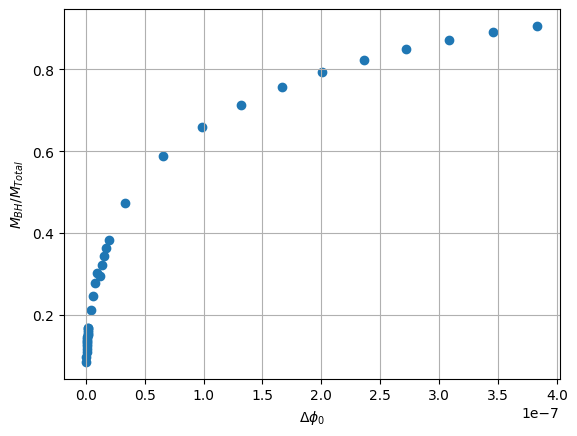

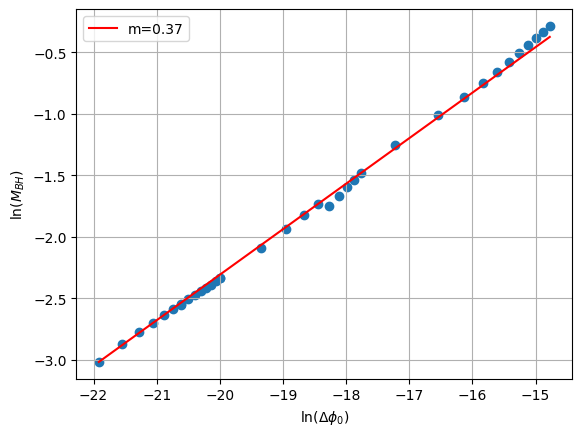

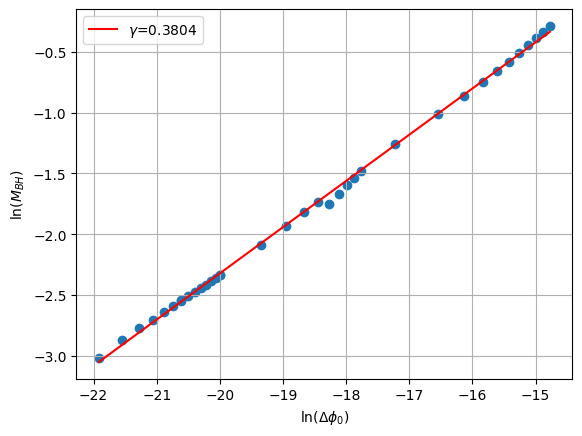

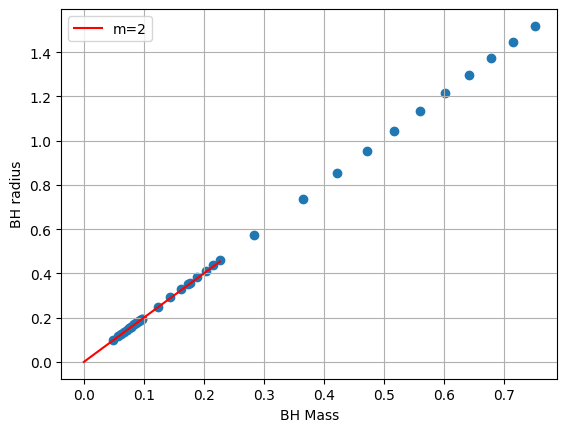

In [7]:
critical_p0 = 1.9154831466382175e-06
critical_radius = 0.078
critical_mass = 0.03925

from scipy.stats import linregress

#Get all radius and p0
from os import listdir
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
#Sort by modification date
folder_files.sort(key=getmtime)

results_df = pd.DataFrame(columns=['Radius','Mass','phi0'])
for i, file in enumerate(folder_files):
    with open('Mass'+file[6:]) as f:
        mass0 = float(f.readline().split(',')[0])
    #Get parameters from the simulation
    BHradius = read_params(file)['BH radius']
    BHmass = read_params(file)['BH mass']
    phi0 = read_params(file)['p0']
    #Add values to the dataframe
    new_row = pd.DataFrame([[BHradius,BHmass,phi0,mass0]],columns=['BHRadius','BHMass','phi0','Mass0'])
    results_df = pd.concat((results_df,new_row),ignore_index=True)
#Plot log(delta r0) vs log(delta phi0)
mass = results_df['BHMass'].values
mass_frac = results_df['BHMass'].values/results_df['Mass0'].values
radius = results_df['BHRadius'].values
dphi = results_df['phi0'].values-critical_p0
log_dr   = np.log(results_df['BHRadius'].values-critical_radius)
log_dp = np.log(dphi)
log_mass = np.log(mass)

plt.scatter(dphi,mass_frac)
plt.ylabel('$M_{BH}/M_{Total}$')
plt.xlabel('$\Delta \phi_0$')
plt.grid()
plt.show()

plt.scatter(log_dp,log_mass)
plt.ylabel('ln($M_{BH}$)')
plt.xlabel('ln($\Delta \phi_0$)')
logM0 = min(log_mass)
logdp_i = min(log_dp)
logdp_f = max(log_dp)
plt.plot((logdp_i,logdp_f),(logM0,logM0+0.37*(logdp_f-logdp_i)),'-r',label='m=0.37')
plt.legend()
plt.grid()
plt.show()

plt.scatter(log_dp,log_mass)
plt.ylabel('ln($M_{BH}$)')
plt.xlabel('ln($\Delta \phi_0$)')
logM0 = min(log_mass)
logdp_i = min(log_dp)
logdp_f = max(log_dp)
fit = linregress(log_dp,log_mass)
plt.plot((logdp_i,logdp_f),(fit.intercept+fit.slope*(logdp_i),fit.intercept+fit.slope*(logdp_f)),'-r',label=f'$\gamma$={fit.slope:.4}$\pm${fit.stderr:.4}')
plt.legend()
plt.grid()
plt.show()

plt.scatter(mass,radius)
plt.ylabel('BH radius')
plt.xlabel('BH Mass')
plt.plot((0,mass[-1]),(0,2*mass[-1]),'-r',label='m=2')
plt.legend()
plt.grid()
plt.show()

# Critical point variable

In [9]:
#Find critical p0 Exp

#Find critical point
import subprocess
import numpy as np

#Define an initial known subcritical and supercritical parameter
sub_p0   = 1.5e-06
super_p0 = 5.0e-06

#Minimum dR for finding the critical point
initial_dR = 0.01
final_dR = 0.0025

#How many iterations to make to find the critical point
critical_iterations = 40

fType = "1"
r0 = "0"
d  = "0"
ko = "0"
maxR = "50"
iterations = "100000"
deltaR = initial_dR
old_radius = 0

for i in range(critical_iterations):
    effective_dR = deltaR*(2**(-3))
    new_p0 = sub_p0 + (super_p0 - sub_p0)/2
    print(f'Now trying p0 = {new_p0}, deltaR = {deltaR} ...')
    output = subprocess.check_output([".\VCollapse.exe",  fType, str(new_p0), r0, d, str(deltaR), maxR, iterations], text=True)
    #Read last output and check if it has a non-zero radius
    last_radius = float(read_params()['BH radius'])
    #If BH has formed, save as new supercritical value
    if last_radius > 0.0:
        super_p0 = new_p0
        delta_radius = np.abs(old_radius - last_radius)
        old_radius = last_radius
        print(f'Parameter is supercritical with r_BH = {last_radius}\n')
        if delta_radius < 2*effective_dR:
            deltaR = deltaR/2
    #If BH hasn't formed, save as new subcritical value
    elif last_radius == 0.0:
        sub_p0 = new_p0
        print('Parameter is subcritical\n')
    if deltaR < final_dR:
        print('Reached max resolution\n')
        break
print('Critical search result:')
print(f'Highest subcritical value is:  p0 = {sub_p0}')
print(f'Lowest supercritical value is: p0 = {super_p0}')

Now trying p0 = 3.2500000000000002e-06, deltaR = 0.01 ...
Parameter is subcritical

Now trying p0 = 4.125e-06, deltaR = 0.01 ...
Parameter is supercritical with r_BH = 1.005

Now trying p0 = 3.6875000000000003e-06, deltaR = 0.01 ...
Parameter is subcritical

Now trying p0 = 3.90625e-06, deltaR = 0.01 ...
Parameter is supercritical with r_BH = 0.62375

Now trying p0 = 3.796875e-06, deltaR = 0.01 ...
Parameter is subcritical

Now trying p0 = 3.8515625e-06, deltaR = 0.01 ...
Parameter is supercritical with r_BH = 0.385

Now trying p0 = 3.824218749999999e-06, deltaR = 0.01 ...
Parameter is subcritical

Now trying p0 = 3.8378906249999995e-06, deltaR = 0.01 ...
Parameter is supercritical with r_BH = 0.31

Now trying p0 = 3.831054687499999e-06, deltaR = 0.01 ...
Parameter is supercritical with r_BH = 0.235

Now trying p0 = 3.827636718749999e-06, deltaR = 0.01 ...
Parameter is supercritical with r_BH = 0.1825

Now trying p0 = 3.825927734374999e-06, deltaR = 0.01 ...
Parameter is supercritical 

In [ ]:
#Make a bunch of runs with p0 higher than critical_p0

critical_p0 = 3.8242189585e-06
p0s = np.logspace(np.log10(1.001*critical_p0),np.log10(1.1*critical_p0),20)

fType = "1"
r0 = "0"
d  = "0"
ko = "0"
deltaR = "0.0025"
maxR = "50"
iterations = "100000"

for p0 in p0s:
    output = subprocess.check_output([".\VCollapse.exe",  fType, str(p0), r0, d, deltaR, maxR, iterations], text=True,)

In [6]:
#Find critical d Exp

#Find critical point
import subprocess
import numpy as np

#Define an initial known subcritical and supercritical parameter
sub_d   = 5
super_d = 3

#Minimum dR for finding the critical point
initial_dR = 0.01
final_dR = 0.0025

#How many iterations to make to find the critical point
critical_iterations = 40

fType = "1"
r0 = "0"
p0 = "4.0e-06"
ko = "0"
maxR = "50"
iterations = "100000"
deltaR = initial_dR
old_radius = 0

for i in range(critical_iterations):
    effective_dR = deltaR*(2**(-3))
    new_d = (super_d + sub_d)/2
    print(f'Now trying d = {new_d}, deltaR = {deltaR} ...')
    output = subprocess.check_output([".\VCollapse.exe",  fType, p0, r0, str(new_d), str(deltaR), maxR, iterations], text=True)
    #Read last output and check if it has a non-zero radius
    last_radius = float(read_params()['BH radius'])
    #If BH has formed, save as new supercritical value
    if last_radius > 0.0:
        super_d = new_d
        delta_radius = np.abs(old_radius - last_radius)
        old_radius = last_radius
        print(f'Parameter is supercritical with r_BH = {last_radius}\n')
        if delta_radius < 2*effective_dR:
            deltaR = deltaR/2
    #If BH hasn't formed, save as new subcritical value
    elif last_radius == 0.0:
        sub_d = new_d
        print('Parameter is subcritical\n')
    if deltaR < final_dR:
        print('Reached max resolution\n')
        break
print('Critical search result:')
print(f'Highest subcritical value is:  d = {sub_d}')
print(f'Lowest supercritical value is: d = {super_d}')

Now trying d = 4.0, deltaR = 0.01 ...
Parameter is subcritical

Now trying d = 3.5, deltaR = 0.01 ...
Parameter is subcritical

Now trying d = 3.25, deltaR = 0.01 ...
Parameter is subcritical

Now trying d = 3.125, deltaR = 0.01 ...
Parameter is supercritical with r_BH = 0.51375

Now trying d = 3.1875, deltaR = 0.01 ...
Parameter is subcritical

Now trying d = 3.15625, deltaR = 0.01 ...
Parameter is supercritical with r_BH = 0.335

Now trying d = 3.171875, deltaR = 0.01 ...
Parameter is subcritical

Now trying d = 3.1640625, deltaR = 0.01 ...
Parameter is supercritical with r_BH = 0.25

Now trying d = 3.16796875, deltaR = 0.01 ...
Parameter is supercritical with r_BH = 0.19

Now trying d = 3.169921875, deltaR = 0.01 ...
Parameter is supercritical with r_BH = 0.1425

Now trying d = 3.1708984375, deltaR = 0.01 ...
Parameter is supercritical with r_BH = 0.09125

Now trying d = 3.17138671875, deltaR = 0.01 ...
Parameter is subcritical

Now trying d = 3.171142578125, deltaR = 0.01 ...
Param

# Various plots

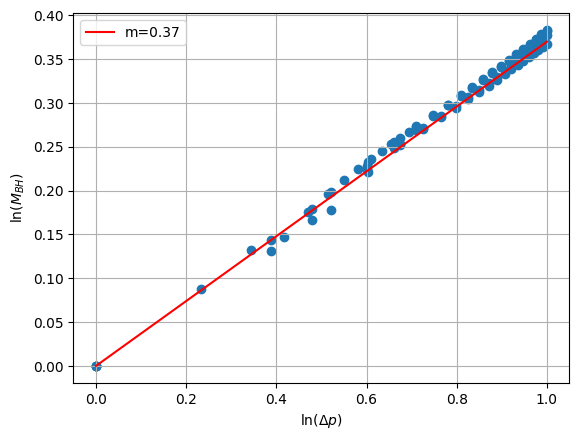

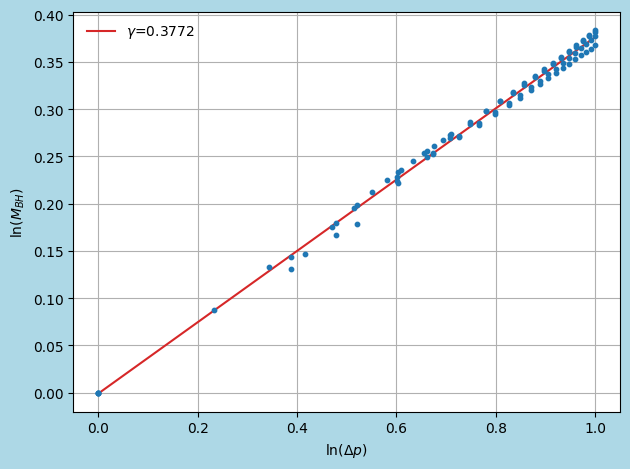

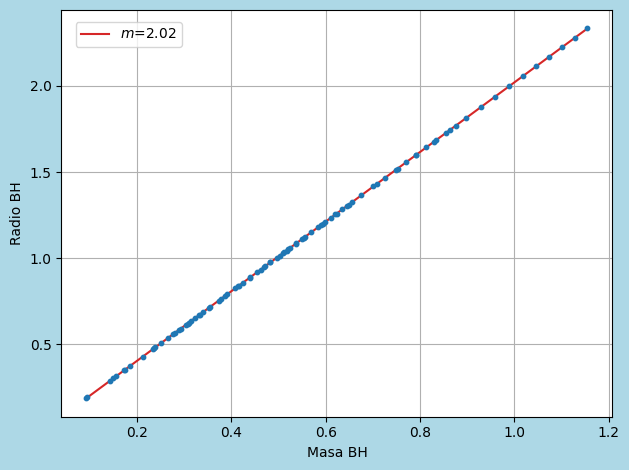

In [22]:
from scipy.stats import linregress

#Get all radius and p0
from os import listdir
#crits = [3.21012112498]
#folders = ['Gamma Variable Tan d']
#Sort by modification date
#all_files.sort(key=getmtime)
def multi_data(folders,crits):
    df = pd.DataFrame(columns=['Radius','Mass','Param','Crit','Type','dp','min logdp','min logm','max logdp'])
    for i, folder in enumerate(folders):
        folder = '.\\'+folder
        folder_files = listdir(folder)
        files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
        crit = crits[i]
        min_logdp = 9999
        max_logdp = -9999
        for j, file in enumerate(files):
            #Get min params from simulation type
            file = folder+'\\'+file
            BHmass = read_params(file)['BH mass']
            if folder.endswith('p0'):
                param = read_params(file)['p0']
            if folder.endswith('d'):
                param = read_params(file)['d']
            log_dp = np.log(np.abs(param-crit))
            log_m = np.log(BHmass)
            if log_dp < min_logdp:
                min_logdp = log_dp
                min_logm = log_m
            if log_dp > max_logdp:
                max_logdp = log_dp

        for j, file in enumerate(files):
            #Get parameters from the simulation
            file = folder+'\\'+file
            BHradius = read_params(file)['BH radius']
            BHmass = read_params(file)['BH mass']
            if folder.endswith('p0'):
                param = read_params(file)['p0']
            if folder.endswith('d'):
                param = read_params(file)['d']
            crit_param = crit
            dp = np.abs(crit_param-param)
            sim_type = i
            #Add values to the dataframe
            new_row = pd.DataFrame([[BHradius,BHmass,param,crit_param,sim_type,dp,min_logdp,min_logm,max_logdp]],
                                columns=['Radius','Mass','Param','Crit','Type','dp','min logdp','min logm','max logdp'])
            df = pd.concat((df,new_row),ignore_index=True)
    return df

crits = [3.8242189585e-06,3.171363875728275,0.046914973185,3.21012112498]
#folders = ['Gamma Variable2 Exp p0','Gamma Variable2 Exp d','Gamma Variable2 Tan p0','Gamma Variable2 Tan d']
folders = ['Gamma Variable Exp p0','Gamma Variable Exp d','Gamma Variable Tan p0','Gamma Variable Tan d']
multi_data(folders,crits)
mass = results_df['Mass'].values
radius = results_df['Radius'].values
dp = np.abs(results_df['Param'].values-results_df['Crit'].values)
log_dp = (np.log(dp) - results_df['min logdp'].values)/(results_df['max logdp'].values-results_df['min logdp'].values)
log_mass = (np.log(mass) - results_df['min logm'].values)/(results_df['max logdp'].values-results_df['min logdp'].values)


plt.scatter(log_dp,log_mass)
plt.ylabel('ln($M_{BH}$)')
plt.xlabel('ln($\Delta p$)')
logM0 = min(log_mass)
logdp_i = min(log_dp)
logdp_f = max(log_dp)
plt.plot((logdp_i,logdp_f),(logM0,logM0+0.37*(logdp_f-logdp_i)),'-r',label='m=0.37')
plt.legend()
plt.grid()
plt.show()

fig,ax=plt.subplots(1,1)
fig.patch.set_facecolor('lightblue')
fit = linregress(log_dp,log_mass)
ax.plot((logdp_i,logdp_f),(fit.intercept+fit.slope*(logdp_i),fit.intercept+fit.slope*(logdp_f)),ls='-',c='tab:red',label=f'$\gamma$={fit.slope:.4}')#$\pm${fit.stderr:.2}')
ax.scatter(log_dp,log_mass,s=10,zorder=2)
ax.set_ylabel('ln($M_{BH}$)')
ax.set_xlabel('ln($\Delta p$)')
ax.grid()
logM0 = min(log_mass)
logdp_i = min(log_dp)
logdp_f = max(log_dp)
fig.legend(loc=(0.13,0.9),framealpha=0.0)
fig.tight_layout()
plt.show()

fig,ax=plt.subplots(1,1)
fig.patch.set_facecolor('lightblue')
fit = linregress(mass,radius)
ax.plot((min(mass),max(mass)),(fit.intercept+fit.slope*(min(mass)),fit.intercept+fit.slope*max(mass)),ls='-',c='tab:red',label=f'$m$={fit.slope:.4}')#$\pm${fit.stderr:.2}')
ax.scatter(mass,radius,s=10,zorder=2)
ax.set_ylabel('Radio BH')
ax.set_xlabel('Masa BH')
ax.grid()
#plt.plot((0,mass[-1]),(0,2*mass[-1]),'-r',label='m=2')
fig.legend(loc=(0.12,0.9))
fig.tight_layout()
plt.show()